<a href="https://colab.research.google.com/github/LennardZuendorf/thesis-files/blob/main/Evaluation_LLM_Interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation of Post Hoc Interpretability Implementations
This notebook was created to run and compare different interpretability methods on previously definied criteria.

### Tested Interpretability Approaches

- LIME (Captum)
- Shapley Values Sampling (Captum)
- KernelSHAP (Captum)
- PartitionSHAP (shap)
- PermutationSHAP (shap)

### Comparison Criteria
- Runtime
- Explanation Quality (Visually)

### Test Model & Packages
Each test were run on GTP-2 open ended text generation, from Huggingface. For masking, attribution/shap value collection and plotting the shap or captum libraries were used.

## Installation, Imports & Setup



### Tokens for Downloads

Without a Github token the different variant of shap cannot be loaded. Without a HGF Token llama cannot load from the huggingface hub.

This is set up for colab, alternatively the commented string variant below can be used. For this replace the string with an actual token.

*   Github [Token Info](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/managing-your-personal-access-tokens)
*   Huggingface [Token Info](https://huggingface.co/docs/hub/security-tokens)


In [ ]:
# grabbing tokens for repository and model access
from google.colab import userdata

gh_token=userdata.get('GITHUB_TOKEN')
hgf_token=userdata.get('HGF_TOKEN')

#gh_token="TOKEN"
#hgf_token="TOKEN"

### Creating Folder

Creating folders to save the plots in

In [ ]:
import os.path
from os import path

if path.exists('/content/gpt-2') == False:
  os.mkdir('/content/gpt-2')

if path.exists('/content/mistral') == False:
  os.mkdir('/content/mistral')

if path.exists('/content/llama2') == False:
  os.mkdir('/content/llama2')

!rm /content/gpt-2/*
!rm /content/mistral/*
!rm /content/llama2/*

rm: cannot remove '/content/gpt-2/*': No such file or directory
rm: cannot remove '/content/mistral/*': No such file or directory
rm: cannot remove '/content/llama2/*': No such file or directory


### Installs and Imports

In [ ]:
# basic installs and additional utilies (usually not needed in colab)
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install ipywidgets
!pip install ipython

# model package installs
!pip install torch

!pip install transformers
!pip install huggingface_hub
!pip install accelerate
!pip install bitsandbytes

In [ ]:
# installing captum package from GitHub repository
!pip install git+https://${gh_token}@github.com/LennardZuendorf/thesis-captum.git

# installing shap package from GitHub repository
!pip install git+https://${gh_token}@github.com/LennardZuendorf/thesis-shap.git

In [ ]:
# basic imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

# model imports
import torch
import transformers

# interpretability import
import shap
import captum

### Model Setup

In [ ]:
from transformers import BitsAndBytesConfig

def get_device():
  if torch.cuda.is_available():
    device = torch.device("cuda")
  else: device = torch.device("cpu")

  return device

# setting device based on available hardware
def gpu_loading_config(max_memory:str):
  n_gpus = torch.cuda.device_count()
  max_memory = max_memory

  bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
  )

  return n_gpus, max_memory, bnb_config

In [ ]:
# setup gpt2 and godel model and tokenizer from huggingface
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSeq2SeqLM

# gpt and godel loading function so this can be run individually
def load_gd_gpt():

  # load tokenizer and model from huggingface
  gpt_tokenizer = AutoTokenizer.from_pretrained("gpt2",  use_fast=True)
  gpt_model = AutoModelForCausalLM.from_pretrained("gpt2")

  # update model config
  gpt_model.config.is_decoder = True
  gpt_model.config.max_new_tokens=25
  gpt_model.config.do_sample=True

  # load tokenizer and model from huggingface
  gd_tokenizer = AutoTokenizer.from_pretrained("microsoft/GODEL-v1_1-large-seq2seq")
  gd_model = AutoModelForSeq2SeqLM.from_pretrained("microsoft/GODEL-v1_1-large-seq2seq")

  # update GODEL model config
  gd_model.config.max_new_tokens=25
  gd_model.config.do_sample=True

  return gpt_model, gpt_tokenizer, gd_model, gd_tokenizer

In [ ]:
# setup mistral model and tokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM

# mistral loading function so this can be run individually
def load_mistral(max_gpu_memory):
  device = get_device()

  if device==torch.device("cuda"):
    n_gpus,max_memory, bnb_config = gpu_loading_config(max_gpu_memory)

    mistral_model = AutoModelForCausalLM.from_pretrained(
        "mistralai/Mistral-7B-Instruct-v0.2",
        quantization_config=bnb_config,
        device_map="auto", # dispatch efficiently the model on the available ressources
        max_memory = {i: max_memory for i in range(n_gpus)},
        token=hgf_token
    )

  else:
    mistral_model=AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")
    mistral_model.to(device)
  mistral_tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")

  # update model config
  mistral_model.config.is_decoder=True
  mistral_model.config.max_new_tokens=25
  mistral_model.config.max_length=25
  mistral_model.config.no_repeat_ngram_size=2
  mistral_model.config.do_sample=True

  return mistral_model, mistral_tokenizer

In [ ]:
# setup llama model and tokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM

# llama loading function so this can be run individually
def load_llama(max_gpu_memory:str):

  device = get_device()

  if device==torch.device("cuda"):
    n_gpus,max_memory, bnb_config = gpu_loading_config(max_gpu_memory)

    llama_model = AutoModelForCausalLM.from_pretrained(
      "meta-llama/Llama-2-7b-chat-hf",
      quantization_config=bnb_config,
      device_map="auto", # dispatch efficiently the model on the available ressources
      max_memory = {i: max_memory for i in range(n_gpus)},
      token=hgf_token
    )
  else:
    llama_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf", token=hgf_token)
  llama_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf", token=hgf_token)

  # update model config
  llama_model.config.is_decoder=True
  llama_model.config.max_new_tokens=25
  llama_model.config.max_length=25
  llama_model.config.no_repeat_ngram_size=2
  llama_model.do_sample=True

  # update tokenizer config
  llama_tokenizer.pad_token = llama_tokenizer.eos_token

  return llama_model, llama_tokenizer

**(Loading all Models in Parallel will overload the 50GB RAM)**

-> load either GPT-2 + GODAL or Mistral or Llama2

In [ ]:
# loading gpt and godel model and tokenizer
gpt_model, gpt_tokenizer, gd_model, gd_tokenizer = load_gd_gpt()

In [ ]:
# loading mistral model and tokenizer
mistral_model, mistral_tokenizer = load_mistral("18000MB")

In [ ]:
# loading llama model and tokenizer
llama_model, llama_tokenizer = load_llama("18000MB")

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

## Evaluation Code

### Utils

In [ ]:
# helper functions to prettyfy plots

# imports
from numpy import ndarray

# format the tokens by removing special tokens and special characters
def format_tokens(tokens: list):
    # define special tokens to remove
    special_tokens = ["[CLS]", "[SEP]", "[PAD]", "[UNK]", "[MASK]", "▁", "Ġ", "</w>"]

    # initialize empty list
    updated_tokens = []

    # loop through tokens
    for t in tokens:
        # remove special token from start of token if found
        if t.startswith("▁"):
            t = t.lstrip("▁")

        # loop through special tokens list and remove from current token if matched
        for s in special_tokens:
            t = t.replace(s, " ")

        # add token to list
        updated_tokens.append(t)

    # return the list of tokens
    return updated_tokens

# function to prettyfy formatting of runtime seconds
def prettyfy_seconds(runtime_float):
  # formats seconds runtime in nice format
  runtime_str = time.strftime("%H:%M:%S", time.gmtime(runtime_float))
  return runtime_str

# function to flatten shap values into a 2d list by summing them up
def flatten_attribution(values: ndarray, axis: int = 0):
    return np.sum(values, axis=axis)

### Captum

In [ ]:
# function to extract sequence attribution
# the input token attribution
def cpt_extract_seq_att(attr, method:str):

  # extract values based on the given method
  if method.lower() in ('kernelshap', 'lime'):
    values=attr.seq_attr.to(torch.device("cpu")).numpy()
  else:
    values=flatten_attribution(attr.token_attr_np.transpose(), axis=1)

  # format the input tokens nicely and check for mismatch
  input_tokens = format_tokens(attr.input_tokens)
  if len(attr.input_tokens) != len(values): raise RuntimeError("values and input len mismatch")

  # return a list of tuples with token and value
  return list(zip(input_tokens,values))

def cpt_extract_tok_att(attr, method:str):
  if method.lower() in ('kernelshap', 'lime'):
    raise RuntimeError(f"{method} doesn't support token attribution.")

  return {
    'input_tokens': format_tokens(attr.input_tokens),
    'values': attr.token_attr_np.transpose(),
    'output_tokens': format_tokens(attr.output_tokens)
  }

In [ ]:
# interpretability creation function for captum powered interpretability methods
from captum.attr import ShapleyValueSampling, KernelShap, Lime, TextTokenInput, LLMAttribution, LLMGradientAttribution

# captum llm attribution runner function
# CREDIT: Adapted from Miglani, V., Yang, A., Markosyan, A.H., Garcia-Olano, D. and Kokhlikyan, N., 2023.
## Using Captum to Explain Generative Language Models. arXiv preprint arXiv:2312.05491.
def captum_llm_attribution(method, test_input, model, tokenizer):
  # deciding which method to use
  match method.lower():
    case "shapley value sampling":
      # creating llm attribution class with handed over shapley value sampling attribution class
      llm_attribution = LLMAttribution(ShapleyValueSampling(model),tokenizer);
      # updating method to be tuple of package and method
      method = ("captum", "Shapley Value Sampling")
    case "kernelshap":
      # creating llm attribution class with handed over shapley value sampling attribution class
      llm_attribution = LLMAttribution(KernelShap(model),tokenizer);
      # updating method to be tuple of package and method
      method = ("captum", "KernelSHAP")
    case "lime":
      # using special attribution class because GradientSHAP is gradient based
      llm_attribution = LLMAttribution(Lime(model),tokenizer);
      # updating method to be tuple of package and method
      method = ("captum", "LIME")
    case _:
      # raises and exception and return empty strings
      raise Exception('Interpretability method could not be detected.');
      return "", "", ""

  # setting input, running attribution with a timer
  attribution_input = TextTokenInput(test_input, tokenizer)
  runtime = time.time()
  attribution_result = llm_attribution.attribute(attribution_input)
  runtime = time.time()-runtime

  # returning result, lib/method tuple and runtime
  return attribution_result, method, runtime

#### Trial Running Code

In [ ]:
# rough testing code for debugging

# getting attribution values, method and runtime
test_cpt_attr, test_cpt_method, test_cpt_runtime = captum_llm_attribution("Shapley Value Sampling", "Does Money buy happiness?", llama_model, llama_tokenizer)

# printing results using utilities
print(f"Ran {test_cpt_method[1]} with {test_cpt_method[0]} for {prettyfy_seconds(test_cpt_runtime)} seconds. See values below:")
print(f"Sequence attribution: {cpt_extract_seq_att(test_cpt_attr, test_cpt_method[0])}")
print(f"Token attribution: {cpt_extract_tok_att(test_cpt_attr, test_cpt_method[0])}")

### shap



In [ ]:
# helper function for shap package powered interpretability methods

# imports
from shap import models, maskers

# wrapper around generative text models to make them usable by shap
def shap_llm_wrapper(model, tokenizer):
  # creates a new teacher forcing model based on the handed over model and tokenizer
  teacher_forcing_model = models.TeacherForcing(model, tokenizer, device="cpu")
  text_masker = maskers.Text(tokenizer, mask_token="...", collapse_mask_token=True)
  # returns new instances
  return teacher_forcing_model, text_masker

# function to extract summarized sequence wise attribution
def shap_extract_seq_att(shap_values):

  # extracting summed up shap values
  values = flatten_attribution(shap_values.values[0], 1)

  # returning list of tuples of token and value
  return list(zip(shap_values.data[0],values))

# function to extract token wise attribution
def shap_extract_tok_att(shap_values):

  # returning a combined standartized dict
  return {
      'input_tokens': shap_values.data[0].tolist(),
      'values': shap_values.values[0],
      'output_tokens': shap_values.output_names
  }

In [ ]:
# interpretability creation function for shap powered interpretability methods

# imports
from shap import PartitionExplainer, PermutationExplainer, KernelExplainer, DeepExplainer

# shap llm explanation runner function
def shap_llm_explanation(method, test_input, model, tokenizer):

  # calling wrapper for new wrapped model and a masker
  shap_model, shap_masker = shap_llm_wrapper(model, tokenizer)

  # deciding which method to use
  match method.lower():
    case "permutationshap":
      # creating Partition Explainer class with wrapped model and new masker
      explainer = PermutationExplainer(shap_model, shap_masker)
      # updating method to be tuple of package and method
      method = ("shap", "PermutationSHAP")
    case "partitionshap":
      # creating Partition Explainer class with wrapped model and new masker
      explainer = PartitionExplainer(model, tokenizer);
      # updating method to be tuple of package and method
      method = ("shap", "PartitionSHAP")
    case _:
      # raises and exception and return empty strings
      raise Exception('Interpretability method could not be detected.');
      return "", "", ""

  # calling explanations and calculating runtime
  runtime = time.time()
  shap_values = explainer([test_input])
  runtime = time.time()-runtime

  # returning result, new method tuple and runtime
  return shap_values, method, runtime

#### Trial Running Code

In [ ]:
# rough testing code for debugging

# getting shap values, method and runtime
test_shap_values, test_shap_method, test_shap_runtime = shap_llm_explanation(method="PartitionSHAP", test_input="Does money buy happiness?", model=gpt_model, tokenizer=gpt_tokenizer)

tmp = shap_extract_tok_att(test_shap_values)

# printing results using utilities
print(f"Ran {test_shap_method[1]} with {test_shap_method[0]} for {prettyfy_seconds(test_shap_runtime)} seconds. See values below:")

(5, 12)
['Does', ' money', ' buy', ' happiness', '?']


## Code for Plotting, Result Collection and Running

### Helper and Plotting Functions

In [ ]:
# plotting functions
from matplotlib.colors import LinearSegmentedColormap

def plot_seq(seq_values:list, method:tuple=("",""), file_path="", model_name:str="gpt-2"):

    # Separate the tokens and their corresponding importance values
    tokens, importance = zip(*seq_values)

    # Convert importance values to numpy array for conditional coloring
    importance = np.array(importance)

    # Determine the colors based on the sign of the importance values
    colors = ['#ff0051' if val > 0 else '#008bfb' for val in importance]

    # Create a bar plot
    plt.figure(figsize=(len(tokens) * 0.9, np.max(importance)))
    x_positions = range(len(tokens))  # Positions for the bars

    # Creating vertical bar plot
    bar_width = 0.8  # Increase this value to make the bars wider
    plt.bar(x_positions, importance, color=colors, align='center', width=bar_width)
    plt.yscale("log")

    # Annotating each bar with its value
    padding = 0.1  # Padding for text annotation
    for x, (y, color) in enumerate(zip(importance, colors)):
        sign = '+' if y > 0 else ''
        plt.annotate(
            f'{sign}{y:.2f}',  # Format the value with sign
            xy=(x, y + padding if y > 0 else y - padding),
            ha='center',
            color=color,
            va='bottom' if y > 0 else 'top',  # Vertical alignment
            fontweight='bold',  # Bold text
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1')  # White background
        )

    plt.axhline(0, color='black', linewidth=1)
    plt.title(f'Input Token Attribution with {method[1]} on {model_name}')
    plt.xlabel('Input Tokens', labelpad=0.5)
    plt.ylabel('Attribution')
    plt.xticks(x_positions, tokens, rotation=45)

    # Adjust y-axis limits to ensure there's enough space for labels
    y_min, y_max = plt.ylim()
    y_range = y_max - y_min
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)

    # Save the plot to a file if file_path is provided
    if file_path != "":
        file_path = f"{file_path}/{method[1]}_sequenceplot.png"
        plt.savefig(file_path)

    return plt, file_path

In [ ]:
def plot_tok(token_attribution_dict:dict, method:tuple=("", ""), file_path="", model_name:str="gpt-2"):
    token_values = token_attribution_dict['values']
    input_tokens = token_attribution_dict['input_tokens']
    output_tokens = token_attribution_dict['output_tokens']

    # Ensure the dimensions of the attribution matrix match the token lists
    assert token_values.shape == (len(input_tokens), len(output_tokens)), \
        "Attribution matrix dimensions must match the lengths of token lists"

    # Define the custom colormap
    cmap = LinearSegmentedColormap.from_list(
        "custom_colormap",
        [(0, '#008bfb'), (0.5, "white"), (1, '#ff0051')]
    )

    # Set the width of the plot dynamically based on the number of output_tokens
    width = max(len(output_tokens) * 0.8, 10)  # Set a minimum width
    height = len(input_tokens) * 0.8

    # Create the heatmap with square boxes
    plt.figure(figsize=(width, height))
    im = plt.imshow(token_values, aspect='auto', cmap=cmap, norm=plt.Normalize(vmin=-1, vmax=1))

    # Annotate the cells with the numerical data
    for i in range(len(input_tokens)):
        for j in range(len(output_tokens)):
            text = plt.text(j, i, f"{token_values[i, j]:.2f}",
                           ha="center", va="center", color="black")

    # Setting the labels for axes
    plt.xlabel('Output Tokens')
    plt.ylabel('Input Tokens')
    plt.title(f'Input x Output Token Attribution Heatmap with {method[1]} on {model_name}')

    # Setting the tick labels for both axes
    plt.xticks(np.arange(len(output_tokens)), output_tokens, rotation=45, ha='right')
    plt.yticks(np.arange(len(input_tokens)), input_tokens)

    plt.colorbar(im)

    # Save the plot to a file if file_path is provided
    if file_path !="":
      file_path=f"{file_path}/{method[1]}_tokenplot.png"
      plt.savefig(file_path)

    return plt, file_path

### Runner and Overall Controller Functions


In [ ]:
# test running functions

# function that runs interpretability methods for each selected method
# collects the results
# and calls plotting runner if selected
def test_runner(methods:list, test_text:str, model, tokenizer,plots:bool, plot_mode:str="show", model_name:str="gpt-2"):
  # assert correct setting of plot mode
  assert plot_mode in ('save','show'), \
  "Mode not supported. Choose 'save' or 'show'."

  # creating a results dataframe
  result_data_raw = empty_df = pd.DataFrame(columns=["framework","method tuple","runtime raw","runtime","seq attribution", "token attribution"], index=methods)

  # looping over all methods and creating explanations
  for method in methods:
    print(f"Running method {method}")
    match method.lower():
      case "partitionshap":
        # calling explanation function for results
        interpretation_result, method_tuple, runtime = shap_llm_explanation("PartitionSHAP", test_text, model, tokenizer)
        # adding various results together
        run_results = [method_tuple[0], method_tuple, runtime, prettyfy_seconds(runtime), shap_extract_seq_att(interpretation_result), shap_extract_tok_att(interpretation_result)]
      case "permutationshap":
        # calling explanation function for results
        interpretation_result, method_tuple, runtime = shap_llm_explanation("PermutationSHAP", test_text, model, tokenizer)
        # adding various results together
        run_results = [method_tuple[0],method_tuple, runtime,prettyfy_seconds(runtime), shap_extract_seq_att(interpretation_result), shap_extract_tok_att(interpretation_result)]
      case "kernelshap":
        # calling explanation function for results
        interpretation_result, method_tuple, runtime = captum_llm_attribution("KernelSHAP", test_text, model, tokenizer)
        # adding various results together
        run_results = [method_tuple[0],method_tuple, runtime,prettyfy_seconds(runtime), cpt_extract_seq_att(interpretation_result, method=method), ""]
      case "shapley value sampling":
        # calling explanation function for results
        interpretation_result, method_tuple, runtime = captum_llm_attribution("Shapley Value Sampling", test_text, model, tokenizer)
        # adding various results together
        run_results = [method_tuple[0],method_tuple, runtime,prettyfy_seconds(runtime), cpt_extract_seq_att(interpretation_result, method=method), cpt_extract_tok_att(interpretation_result, method=method)]
      case "lime":
        # calling explanation function for results
        interpretation_result, method_tuple, runtime = captum_llm_attribution("LIME", test_text, model, tokenizer)
        # adding various results together
        run_results = [method_tuple[0],method_tuple, runtime,prettyfy_seconds(runtime), cpt_extract_seq_att(interpretation_result, method=method), ""]
      case _:
        # raising exception of method not supported or set wrong
        raise Exception("Wrong method given!")
    # adding results of current run to dataframe
    result_data_raw.loc[method] = run_results

  # plotting code only running when set true
  if plots == True:
    # calling plot runner to get plots and file paths
    result_data_raw, plots = plot_runner(result_data_raw, plot_mode, model_name)

    if plot_mode == "show":
      for i, (seq_plot, tok_plot) in enumerate(plots):
        print(f"Plotting Plots for {methods[i]} with {result_data_raw.iloc[i]['framework']}\n")
        seq_plot.show()
        print("\n")
        if tok_plot != "":
          tok_plot.show()

    if plot_mode == "save":
      print("Saved plots to the given file names! \n")

  # return if plots are turned off
  else:
    print("No plotting because plotting is turned off! \n")
    # creating a clean dataframe to return

  # final return of cleaned up dataframe
  return result_data_raw.drop(columns=['runtime raw','method tuple','seq attribution','token attribution'])

def plot_runner(result_data, plot_mode:str, model_name:str):
  assert plot_mode in ('save','show'), \
    "Mode not supported. Choose 'save' or 'show'."

  if plot_mode == "save":
    base_path = f"{model_name.lower()}"
  else: base_path = ""

  seq_file_paths=[]
  token_file_paths=[]
  plots = []

  # looping over results dataframe
  for label, row_data in result_data.iterrows():

    # programmatically setting filepath for saving
    # needs to be empty
    seq_plot, seq_file_path = plot_seq(result_data.at[label, "seq attribution"], result_data.at[label, "method tuple"], file_path=base_path, model_name=model_name)
    if result_data.at[label, "token attribution"] != "":
      tok_plot, token_file_path = plot_tok(result_data.at[label, "token attribution"], result_data.at[label, "method tuple"], file_path=base_path, model_name=model_name)
    else: token_file_path, tok_plot = "", ""

    seq_file_paths.append(seq_file_path)
    token_file_paths.append(token_file_path)
    plots.append((seq_plot,tok_plot))

  if plot_mode == "save":
    result_data['seq plot path'] = seq_file_paths
    result_data['token plot path'] = token_file_paths

  return result_data, plots

## Run Comannd & Result Display


#### running with gpt-2

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Running method KernelShap


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Running method LIME


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Running method Shapley Value Sampling


2024-02-02 09:58:12.917 | DEBUG    | shap.models._teacher_forcing:__init__:50 - Initalized a TecherForcing Model.
2024-02-02 09:58:12.920 | DEBUG    | shap.utils.transformers:is_transformers_lm:97 - Model has been detected as a transformers model: (<class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'>)
2024-02-02 09:58:12.922 | DEBUG    | shap.utils.transformers:is_transformers_lm:97 - Model has been detected as a transformers model: (<class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'>)
2024-02-02 09:58:12.923 | DEBUG    | shap.models._teacher_forcing:__init__:50 - Initalized a TecherForcing Model.
2024-02-02 09:58:12.924 | DEBUG    | shap.explainers._partition:__init__:67 - Initalized PartitionSHAP Explainer class.
2024-02-02 09:58:12.925 | DEBUG    | shap.explainers._partition:__call__:127 - Called PartitionSHAP Explainer.
2024-02-02 09:58:12.926 | DEBUG    | shap.explainers._partition:explain_row:137 - Running explain_row with None of type <class 'NoneType'>


Running method PartitionSHAP


2024-02-02 09:58:13.899 | DEBUG    | shap.models._teacher_forcing:__call__:95 - Called Teacher Forcing Model to compute long odds
2024-02-02 09:58:14.011 | DEBUG    | shap.models._teacher_forcing:__call__:126 - Calculated log odds: [[-7.00276416 -0.60510518 -5.55433361 -1.09985227 -3.51825412 -0.05393046
  -5.31155354 -1.67380263 -0.02190004 -4.90343096 -3.38873655 -6.24827867
  -1.9769572  -3.68068124 -5.32306739 -0.5398893  -0.4955141  -0.91641195
  -1.38890123 -4.71680742 -0.51496992  1.04417439 -1.86382384 -3.66723712
  -3.15261509 -0.51019972 -3.91342849 -0.73924627  0.215971   -0.62702566
   6.49084659 -2.5968911   1.21962519 -5.98032006 -2.19947431  2.68693712
  -3.99063543 -6.27994479  1.31208029 -0.79059891  0.4077775  -1.51212287
  -1.18816637 -3.89837339 -4.56134248 -0.77999165 -1.79434058 -3.85581511
  -3.71561776  6.38573216]]
2024-02-02 09:58:14.012 | DEBUG    | shap.utils._masked_model:_full_masking_call:75 - Did a full masking call with a mask.
2024-02-02 09:58:14.014 |

Saved plots to the given file names! 



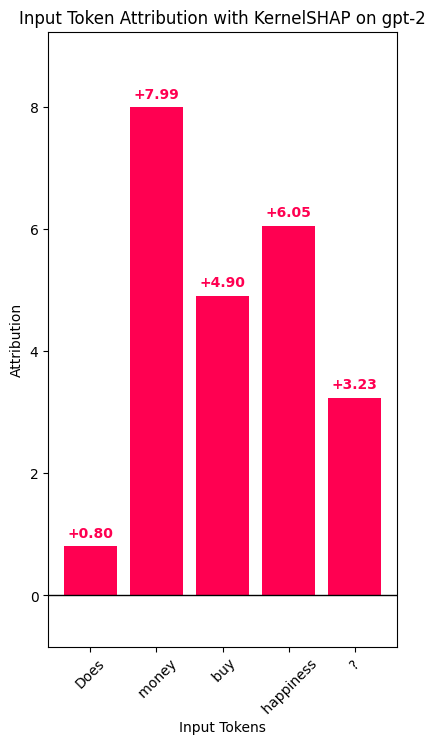

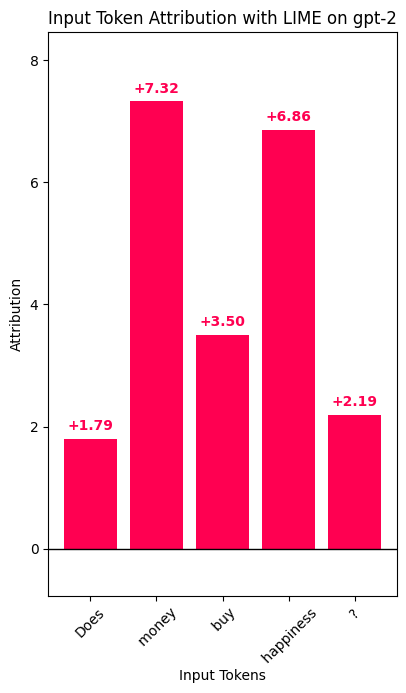

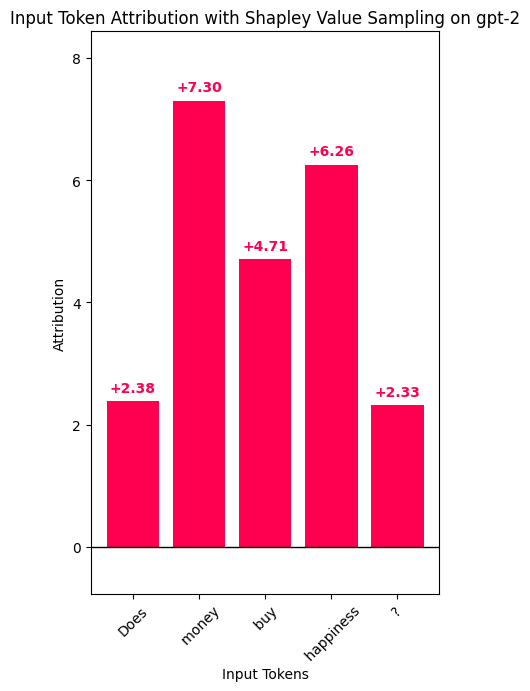

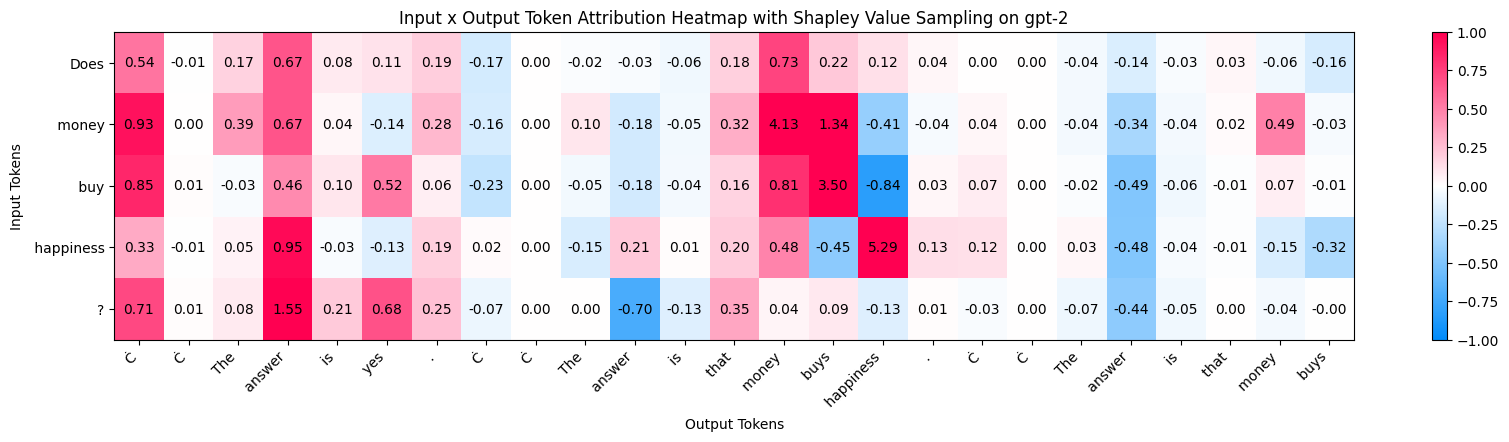

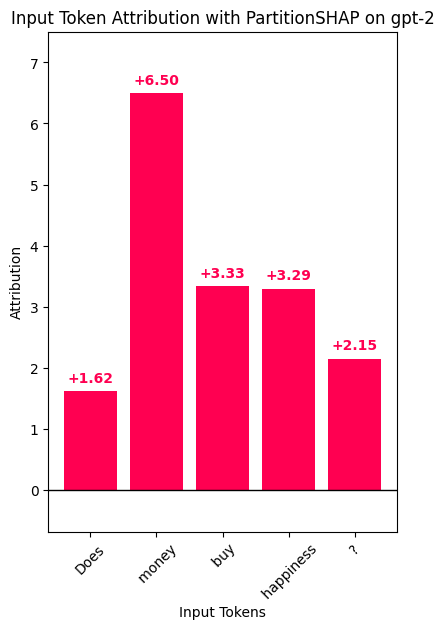

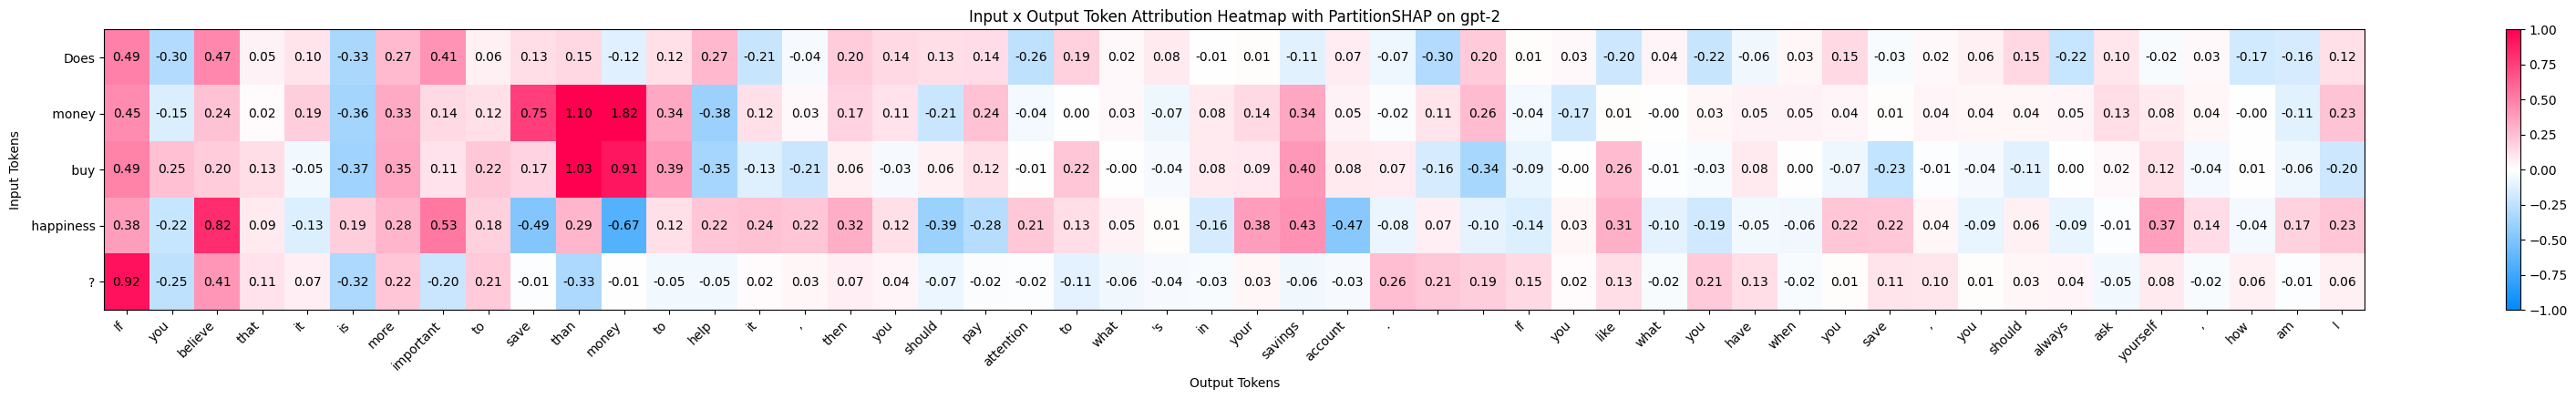

In [ ]:
# using runner to get results, plots, etc. with gpt-2
gpt_test_results=test_runner(methods=["KernelShap", "LIME","Shapley Value Sampling", "PartitionSHAP"], test_text="Does money buy happiness?", model=gpt_model, tokenizer=gpt_tokenizer, plots=True, plot_mode="save", model_name="gpt-2")
# display the test results
gpt_test_results.to_csv("gpt-2/results.csv")

#### running with godel

In [ ]:
# formatting function to formatting input for the model
# CREDIT: Adapted from official interference example on Huggingface
## see https://huggingface.co/microsoft/GODEL-v1_1-large-seq2seq
def gd_format_prompt(message: str="Does money buy happiness?", system_prompt: str="Given a dialog context, you need to respond empathically.", knowledge: str = ""):

    # adds knowledge text if not empty
    if knowledge != "":
        knowledge = "[KNOWLEDGE] " + knowledge

    # adds the message to the prompt
    prompt = f" {message}"
    # combines the entire prompt
    full_prompt = f"{system_prompt} [CONTEXT] {prompt} {knowledge}"

    # returns the formatted prompt
    return full_prompt

2024-02-02 09:54:59.476 | DEBUG    | shap.models._teacher_forcing:__init__:50 - Initalized a TecherForcing Model.
2024-02-02 09:54:59.479 | DEBUG    | shap.utils.transformers:is_transformers_lm:97 - Model has been detected as a transformers model: (<class 'transformers.models.t5.modeling_t5.T5ForConditionalGeneration'>)
2024-02-02 09:54:59.481 | DEBUG    | shap.utils.transformers:is_transformers_lm:97 - Model has been detected as a transformers model: (<class 'transformers.models.t5.modeling_t5.T5ForConditionalGeneration'>)
2024-02-02 09:54:59.482 | DEBUG    | shap.models._teacher_forcing:__init__:50 - Initalized a TecherForcing Model.
2024-02-02 09:54:59.483 | DEBUG    | shap.explainers._partition:__init__:67 - Initalized PartitionSHAP Explainer class.
2024-02-02 09:54:59.483 | DEBUG    | shap.explainers._partition:__call__:127 - Called PartitionSHAP Explainer.
2024-02-02 09:54:59.484 | DEBUG    | shap.explainers._partition:explain_row:137 - Running explain_row with None of type <clas

Running method PartitionSHAP


2024-02-02 09:55:01.987 | DEBUG    | shap.models._teacher_forcing:__call__:95 - Called Teacher Forcing Model to compute long odds
2024-02-02 09:55:02.449 | DEBUG    | shap.models._teacher_forcing:__call__:126 - Calculated log odds: [[-14.08420006  -9.10016985  -3.10147118  -2.0624897   -1.37342602
   -3.86353527  -2.53952056  -5.42820987  -2.24229787   1.39243454
   -5.15638277  -3.05089772  -1.59094287  -2.03069472   2.4398077
    1.42232308  -4.46995054  -0.48798374  -3.1568076   -4.67396081
   -0.13096066  -1.08327017   5.03511203  -2.97330323  -4.04599904
   -3.35385506  -3.06105691   1.50464414  -2.1637485    0.42828553
   -0.80180447  -1.83618627   3.95961393  -0.20035673  -4.29471104
    1.68103287  -7.33968111  -2.74733764]]
2024-02-02 09:55:02.450 | DEBUG    | shap.utils._masked_model:_full_masking_call:75 - Did a full masking call with a mask.
2024-02-02 09:55:02.453 | DEBUG    | shap.models._teacher_forcing:__call__:95 - Called Teacher Forcing Model to compute long odds
2024

  0%|          | 0/498 [00:00<?, ?it/s]

2024-02-02 09:55:11.717 | DEBUG    | shap.explainers._partition:owen:308 - Should be adding new nodes, 0 of 5
2024-02-02 09:55:11.719 | DEBUG    | shap.explainers._partition:owen:308 - Should be adding new nodes, 1 of 5
2024-02-02 09:55:11.720 | DEBUG    | shap.explainers._partition:owen:308 - Should be adding new nodes, 2 of 5
2024-02-02 09:55:11.721 | DEBUG    | shap.explainers._partition:owen:308 - Should be adding new nodes, 3 of 5
2024-02-02 09:55:11.722 | DEBUG    | shap.explainers._partition:owen:308 - Should be adding new nodes, 4 of 5
2024-02-02 09:55:11.728 | DEBUG    | shap.utils._masked_model:_full_masking_call:75 - Did a full masking call with a mask.
2024-02-02 09:55:11.731 | DEBUG    | shap.models._teacher_forcing:__call__:95 - Called Teacher Forcing Model to compute long odds
2024-02-02 09:55:13.157 | DEBUG    | shap.models._teacher_forcing:__call__:126 - Calculated log odds: [[-15.58297783 -10.153252    -3.94610263  -2.15432369  -1.77929371
   -2.62931918  -2.37911223 

Saved plots to the given file names! 



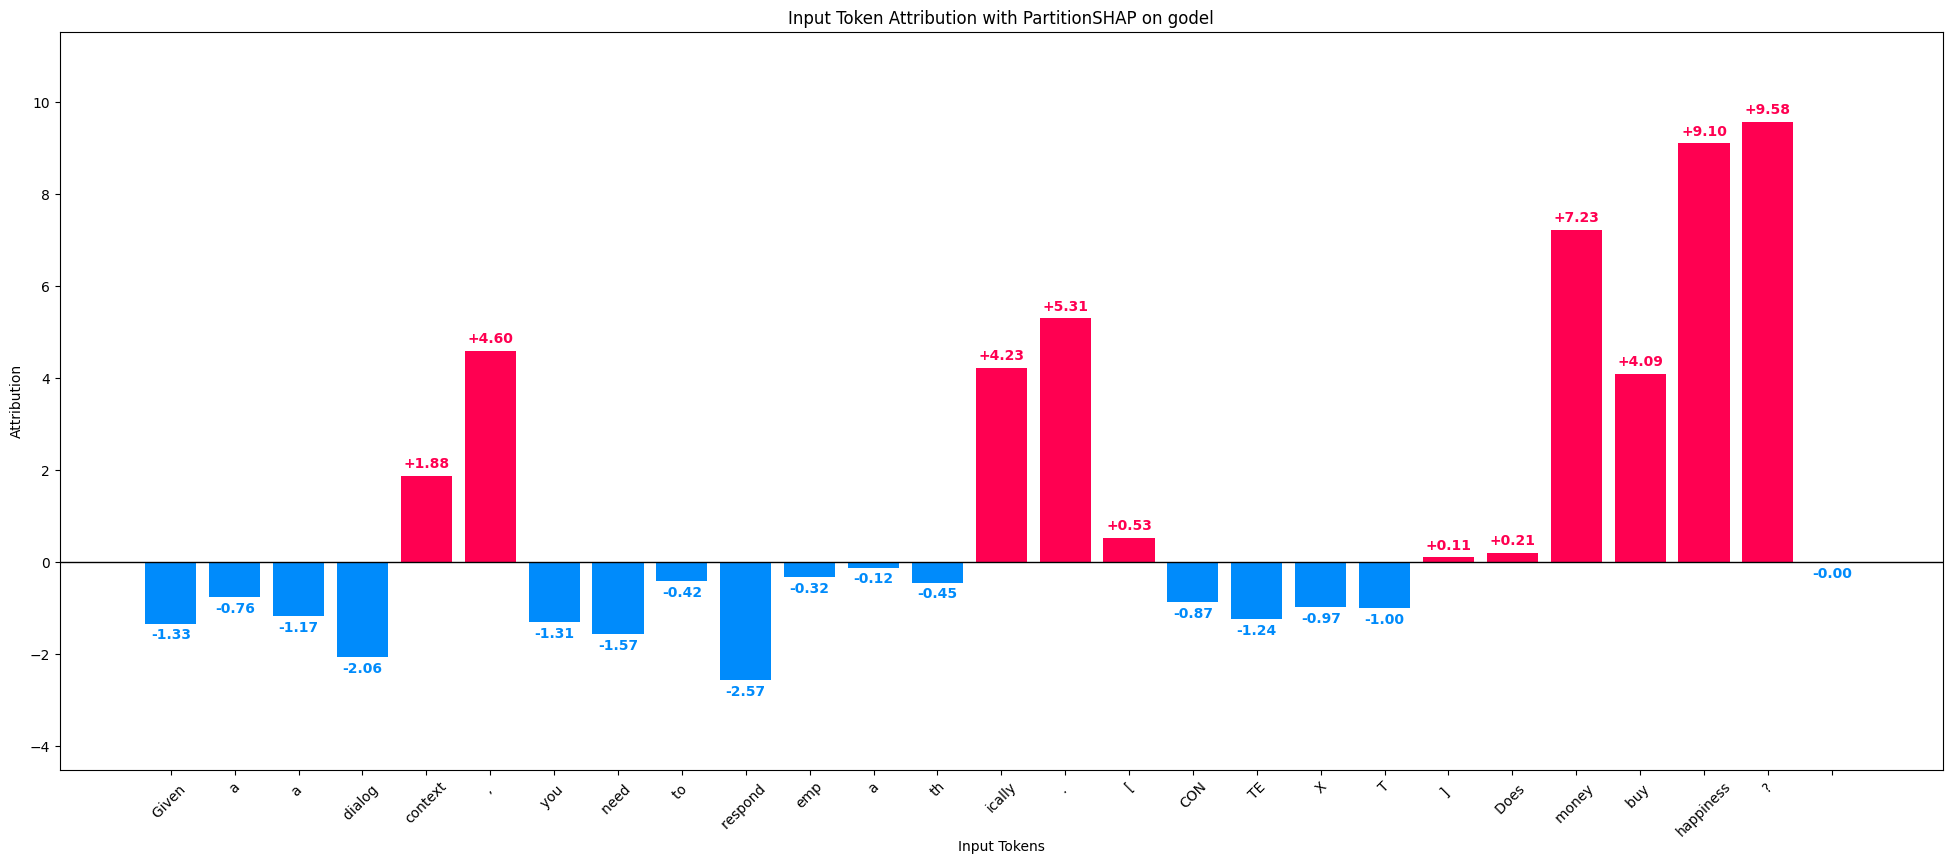

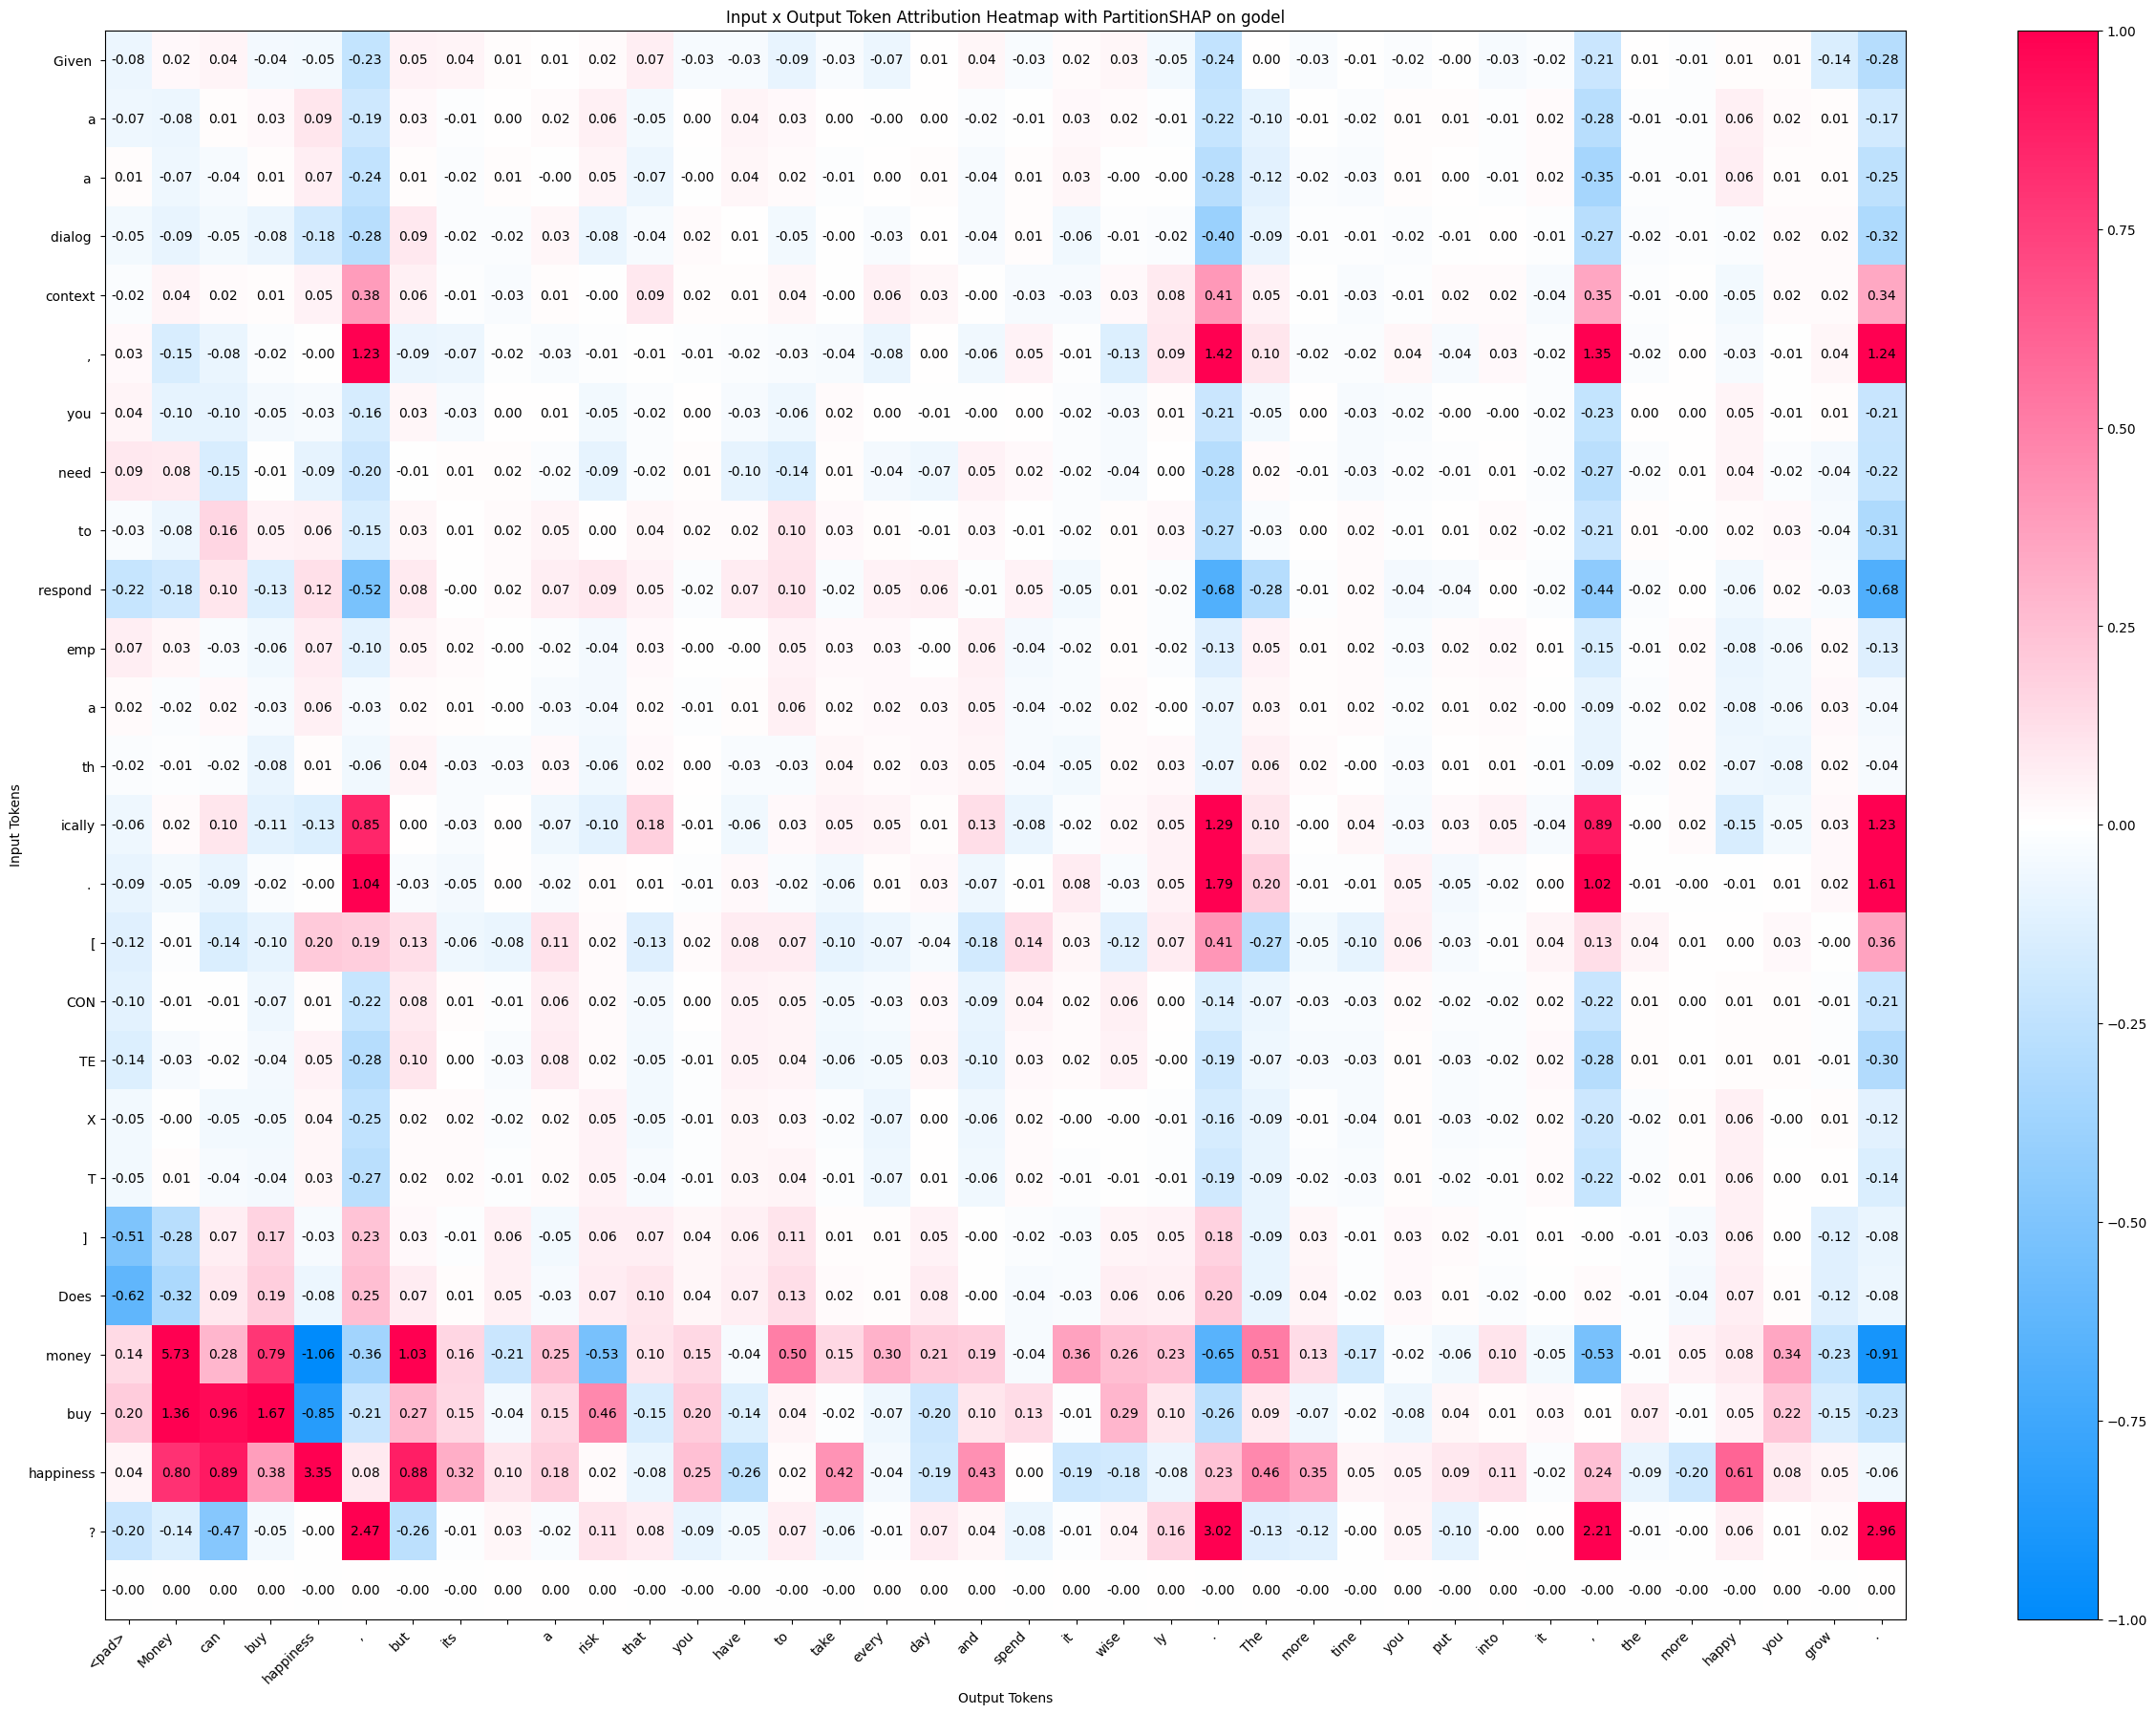

In [ ]:
# using runner to get results, plots, etc. with godel
gd_test_results=test_runner(methods=["PartitionSHAP"], test_text=gd_format_prompt(), model=gd_model, tokenizer=gd_tokenizer, plots=True, plot_mode="save", model_name="godel")
# display the test results
gd_test_results.to_csv("godel/results.csv")

#### running with mistral

In [ ]:
# formatting function to format input for the model
# CREDIT: Inspired by offical documentation and example on Huggingface
## see https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1
def mistral_format_prompt(message: str="Does money buy happiness?", system_prompt: str="Given a dialog context, you need to respond empathically."):
    prompt = f"<s>[INST] {system_prompt} [/INST] Hello, how can I assist you today?</s>[INST] {message} [/INST]"
    return prompt

You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Running method KernelSHAP


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Running method LIME


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.075e+00, tolerance: 1.077e+00
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Running method Shapley Value Sampling
Saved plots to the given file names! 



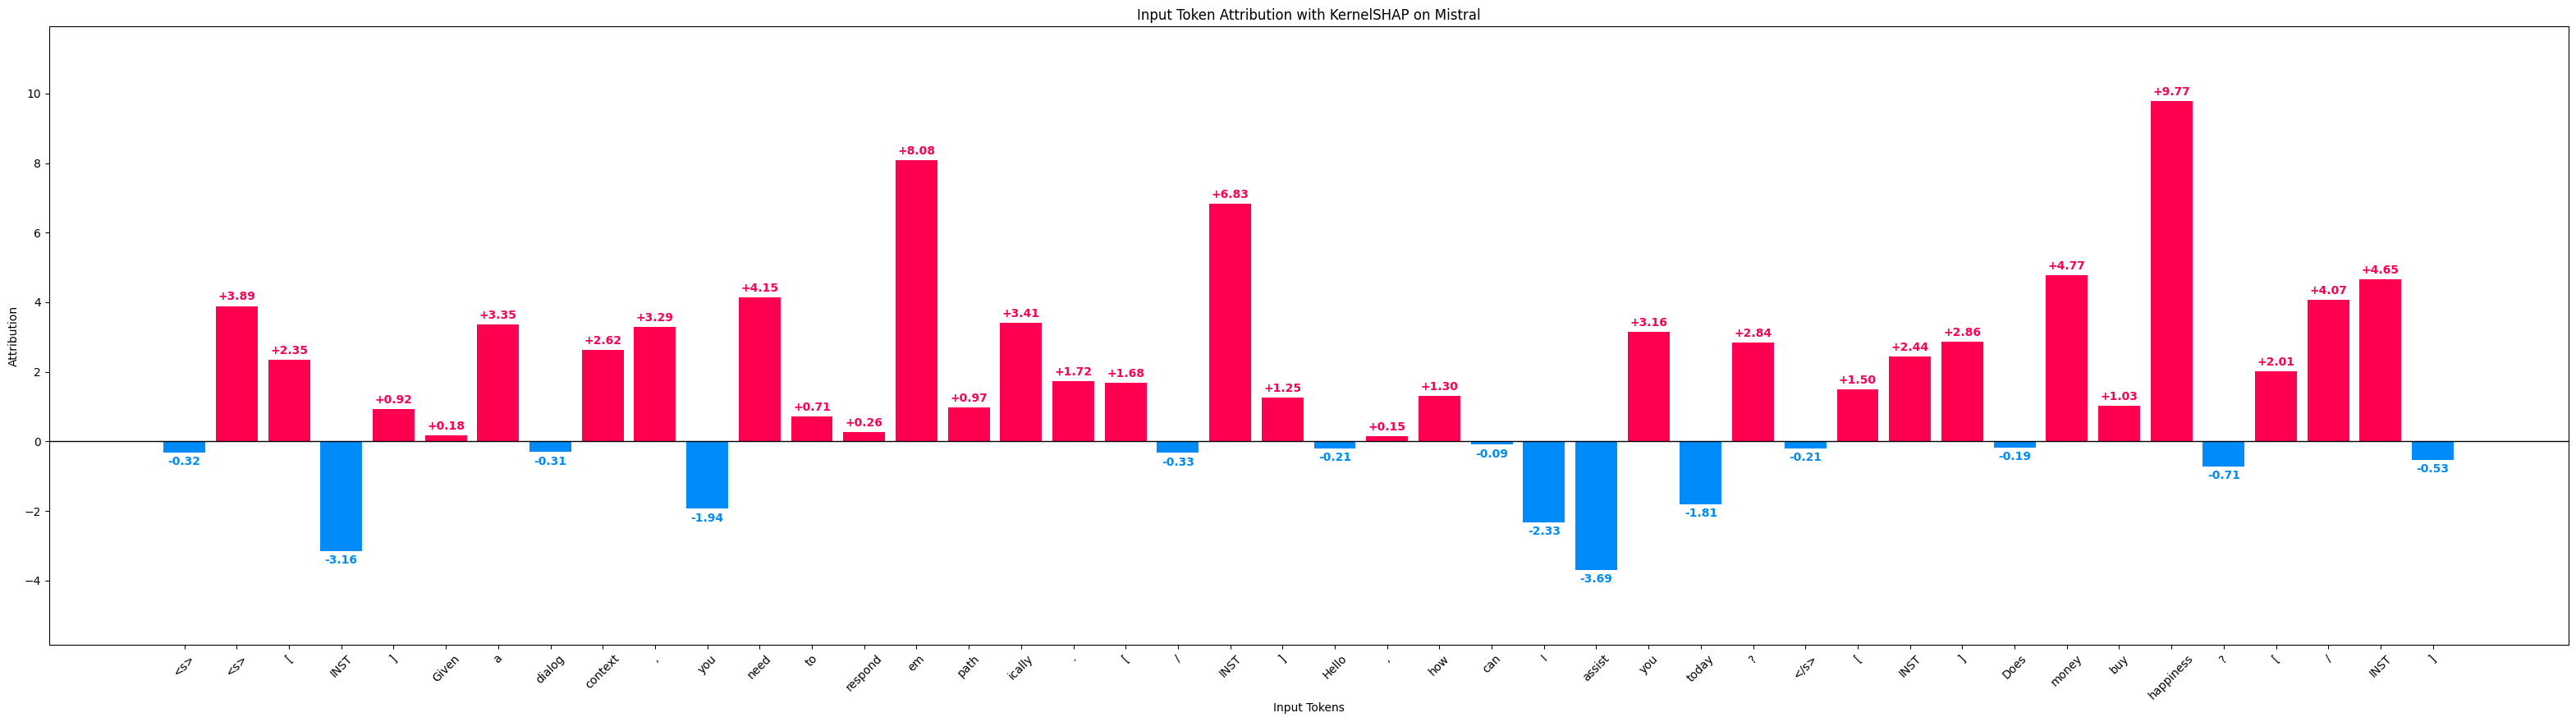

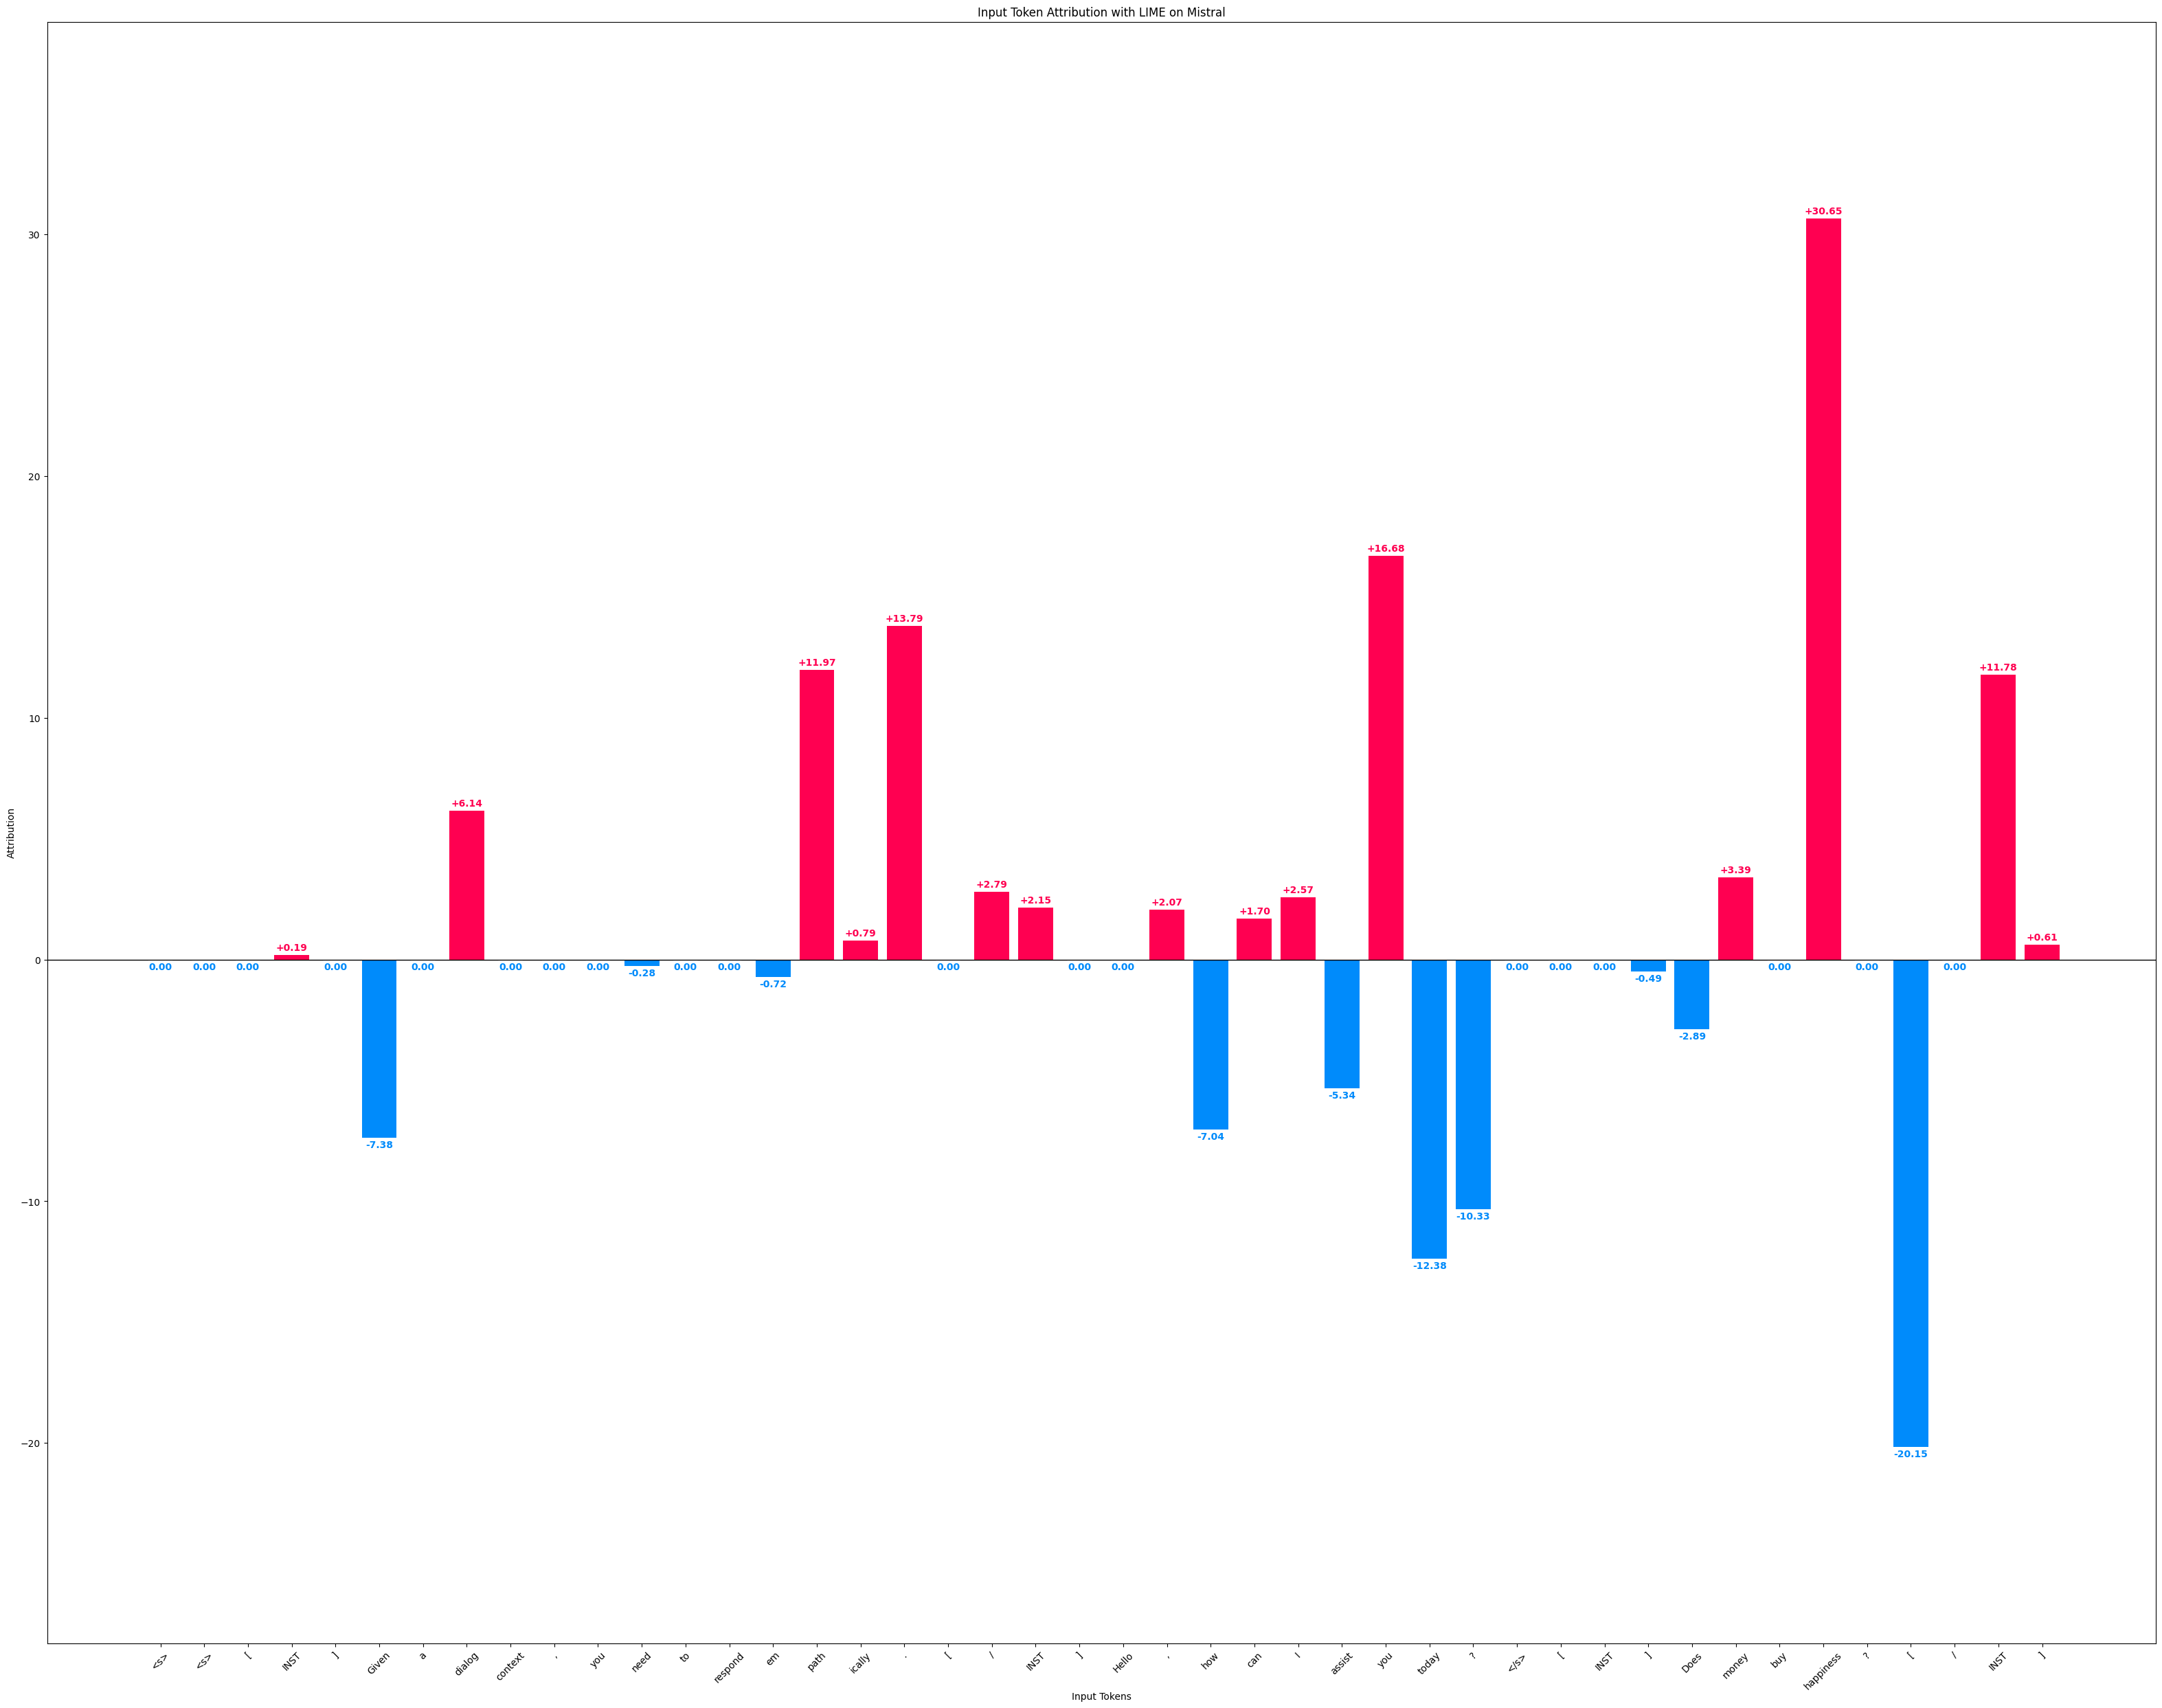

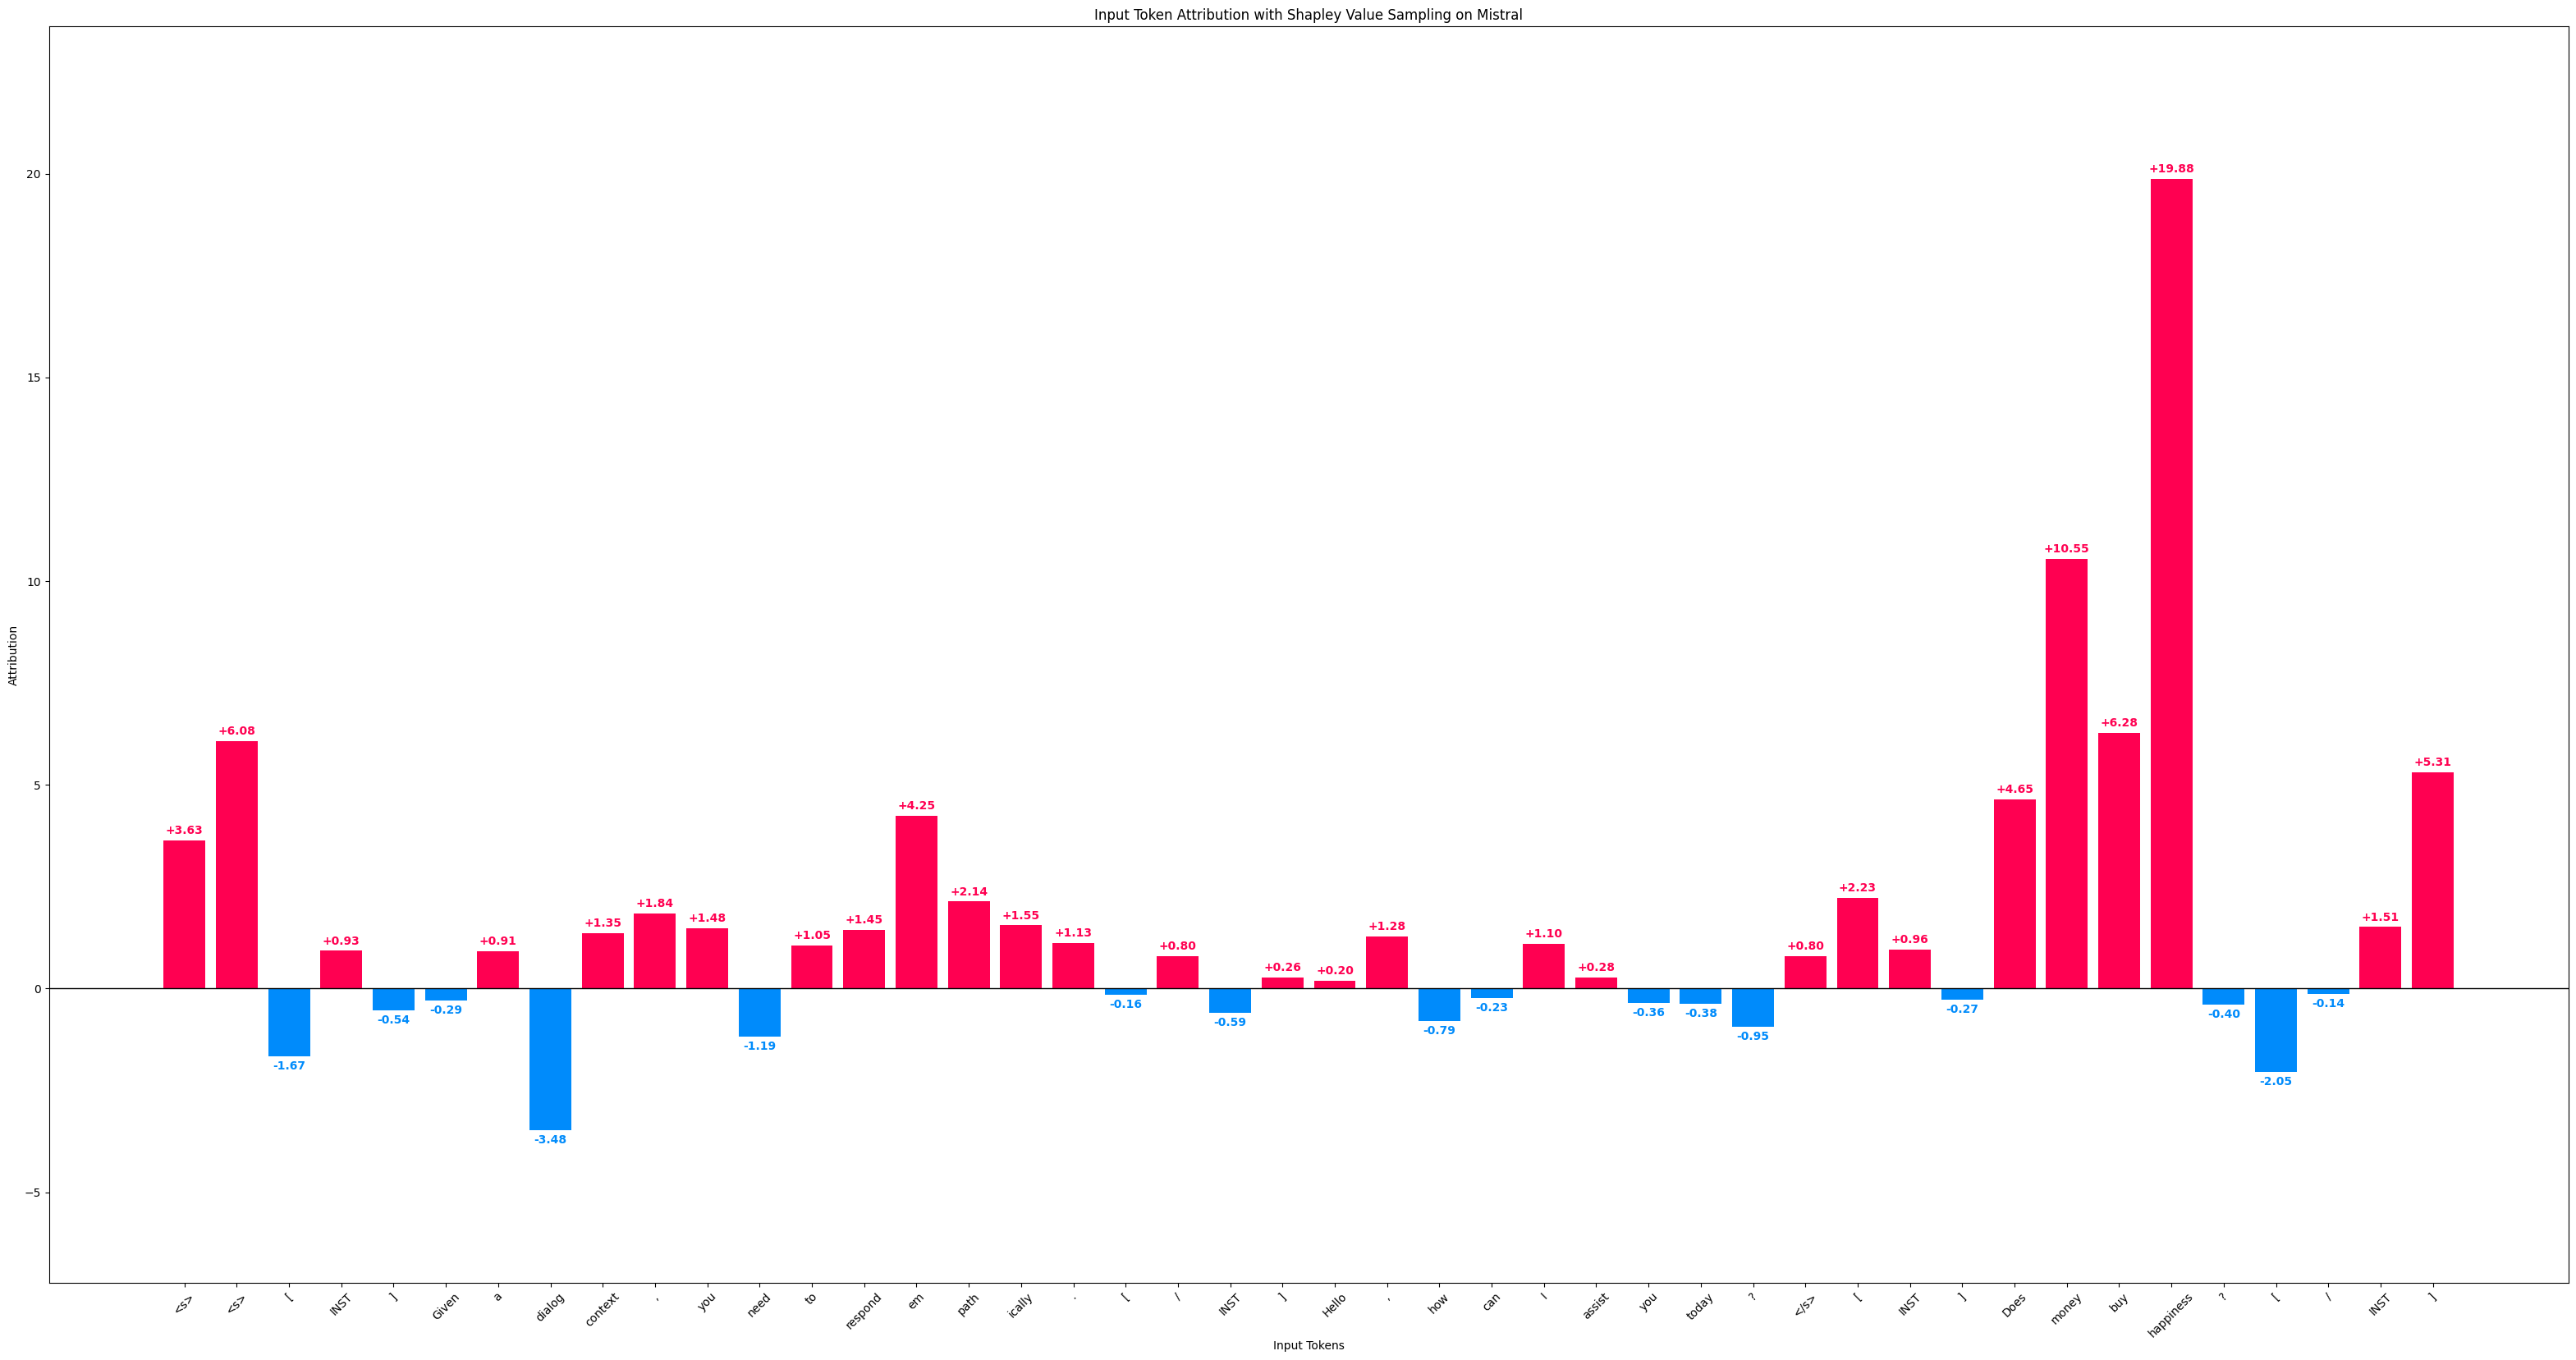

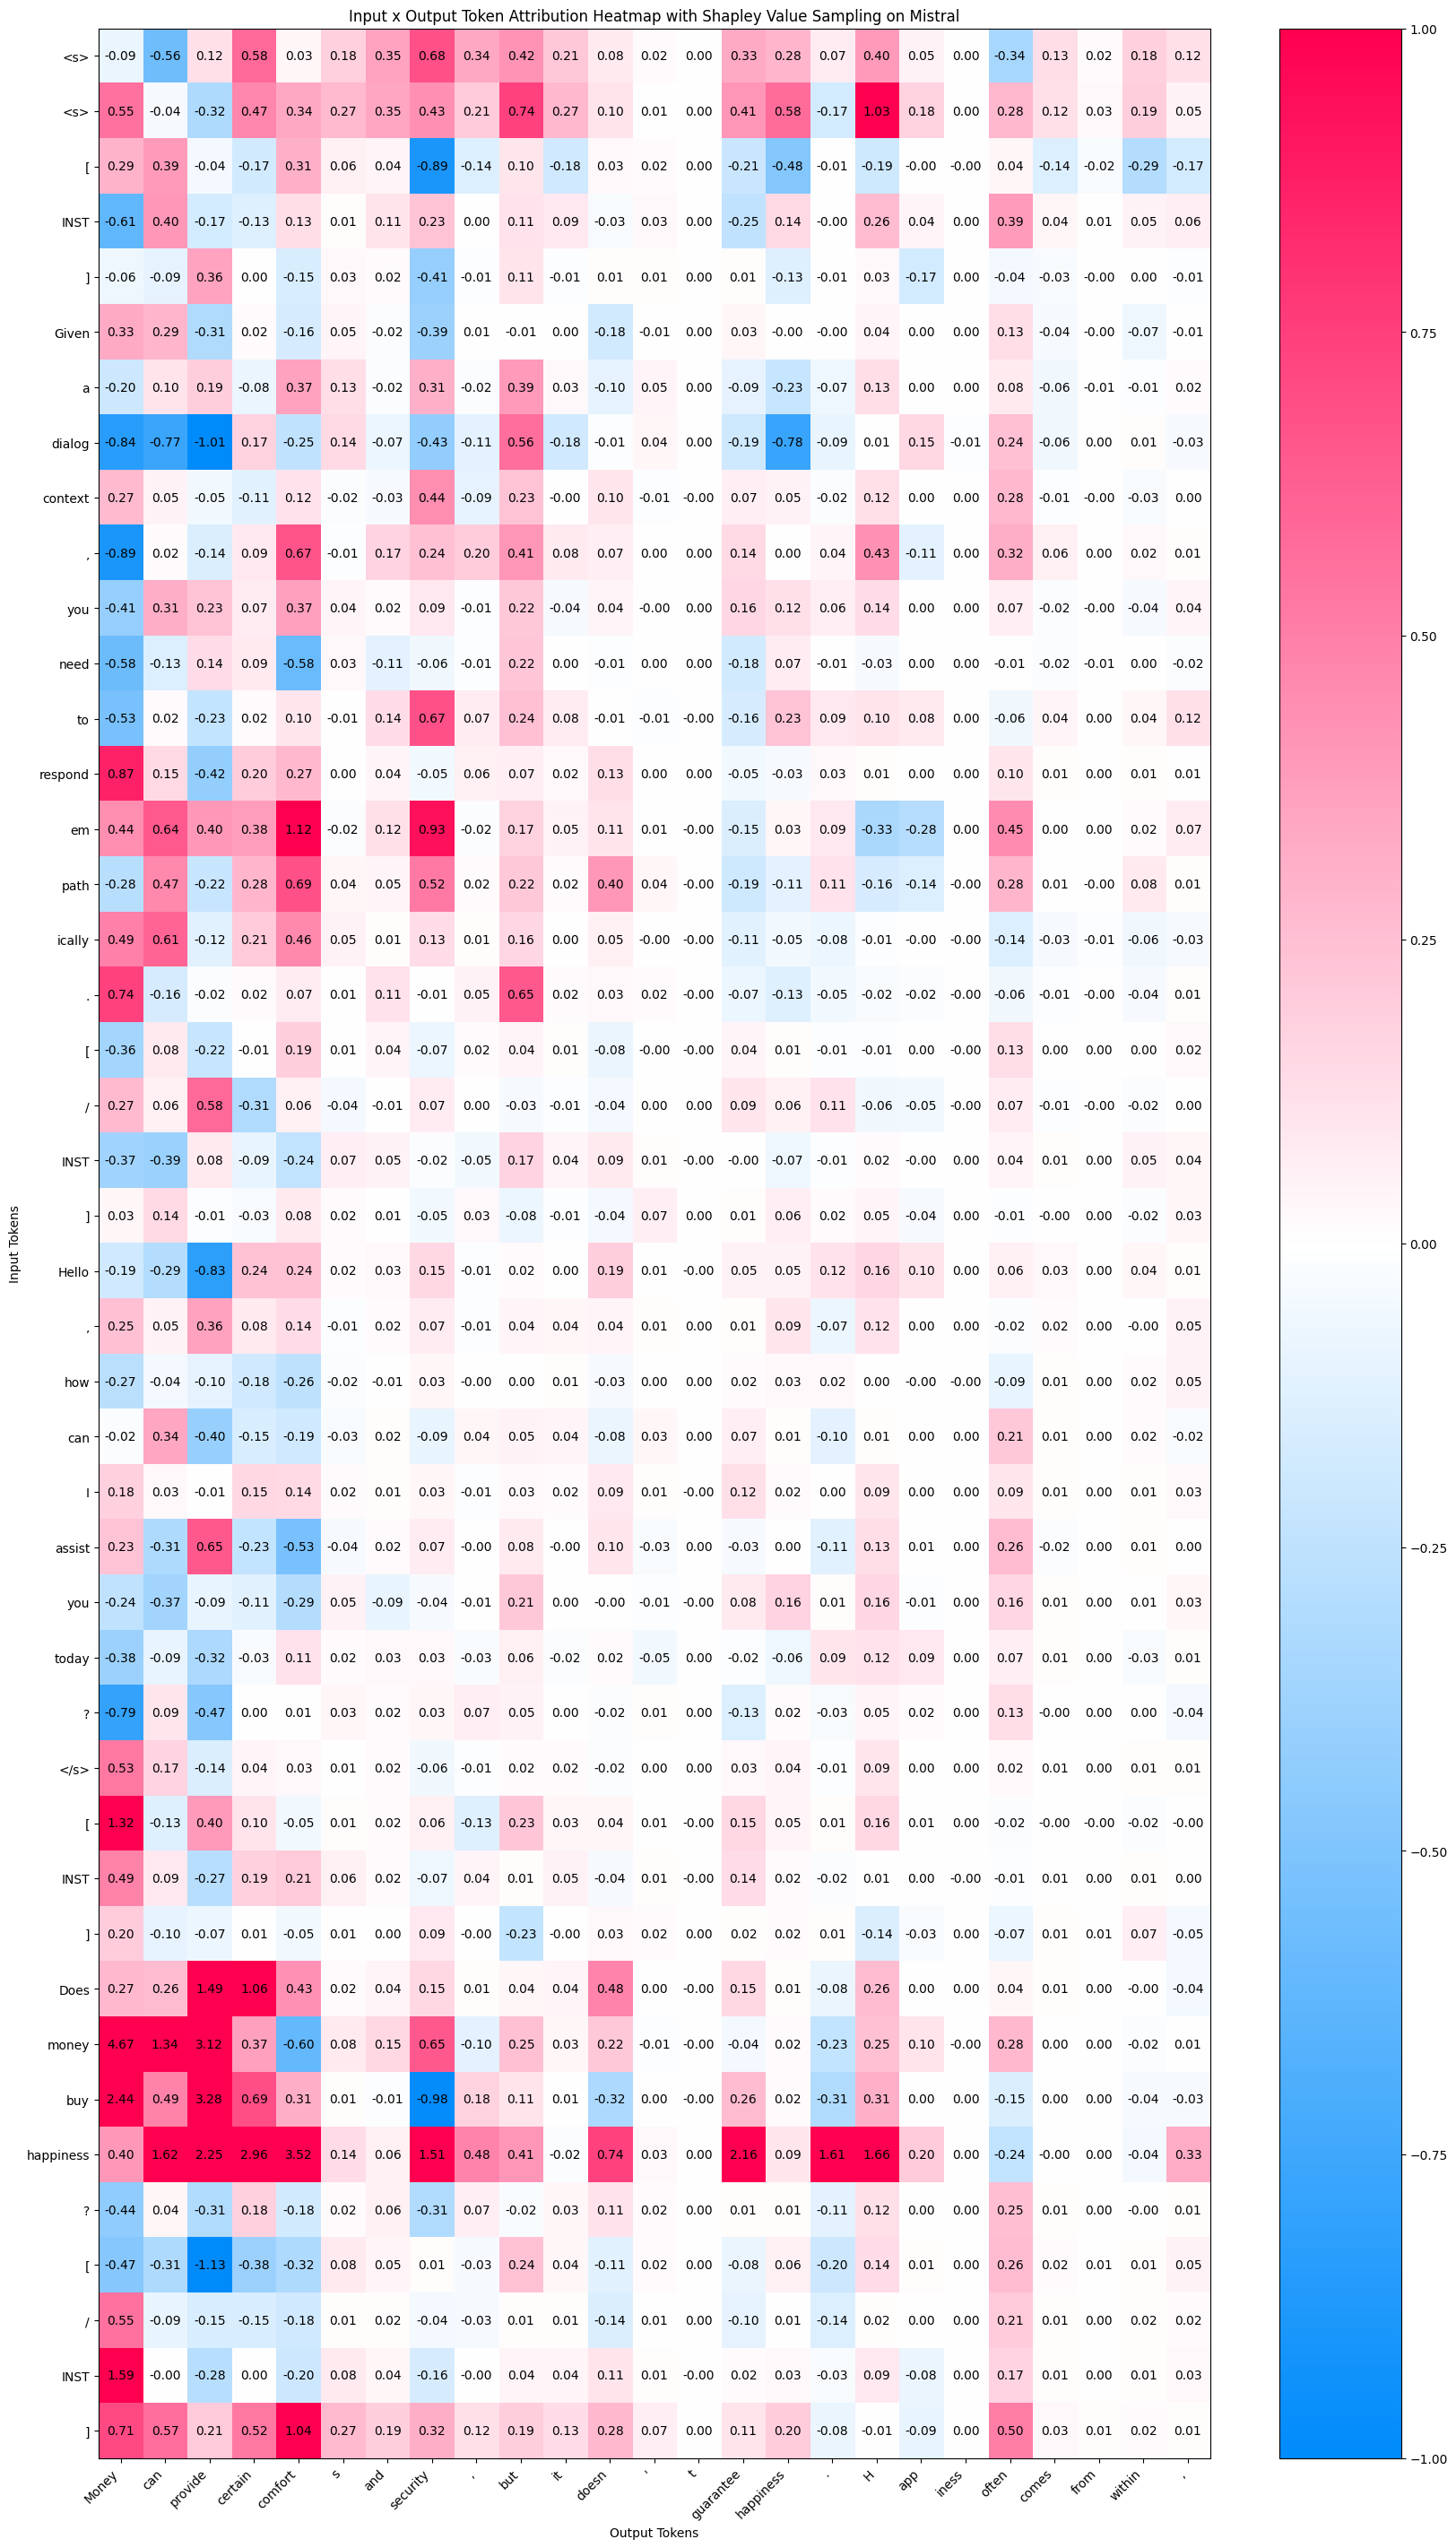

In [ ]:
# using runner to get results, plots, etc. with gpt-2
mistral_test_results=test_runner(methods=["KernelSHAP", "LIME", "Shapley Value Sampling"], test_text=mistral_format_prompt(), model=mistral_model, tokenizer=mistral_tokenizer, plots=True, plot_mode="save", model_name="Mistral")
# display the test results
mistral_test_results.to_csv("mistral/results.csv")

#### running with llama 2

In [ ]:
# formatting function to format input for the model
# CREDIT: Adapted from Philipp Schmid
## see https://www.philschmid.de/llama-2#how-to-prompt-llama-2-chat
def llama_format_prompt(message:str="Does money buy happiness?", system_prompt:str="Given a dialog context, you need to respond empathically."):
  prompt = f"<s>[INST] <<SYS>>\n{system_prompt}\n<</SYS>>\n\n{message} [/INST]"
  return prompt

Running method KernelSHAP


`do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
`do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.


Running method LIME


`do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
`do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.215e-01, tolerance: 1.242e-01
`do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
`do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.


Running method Shapley Value Sampling
Saved plots to the given file names! 



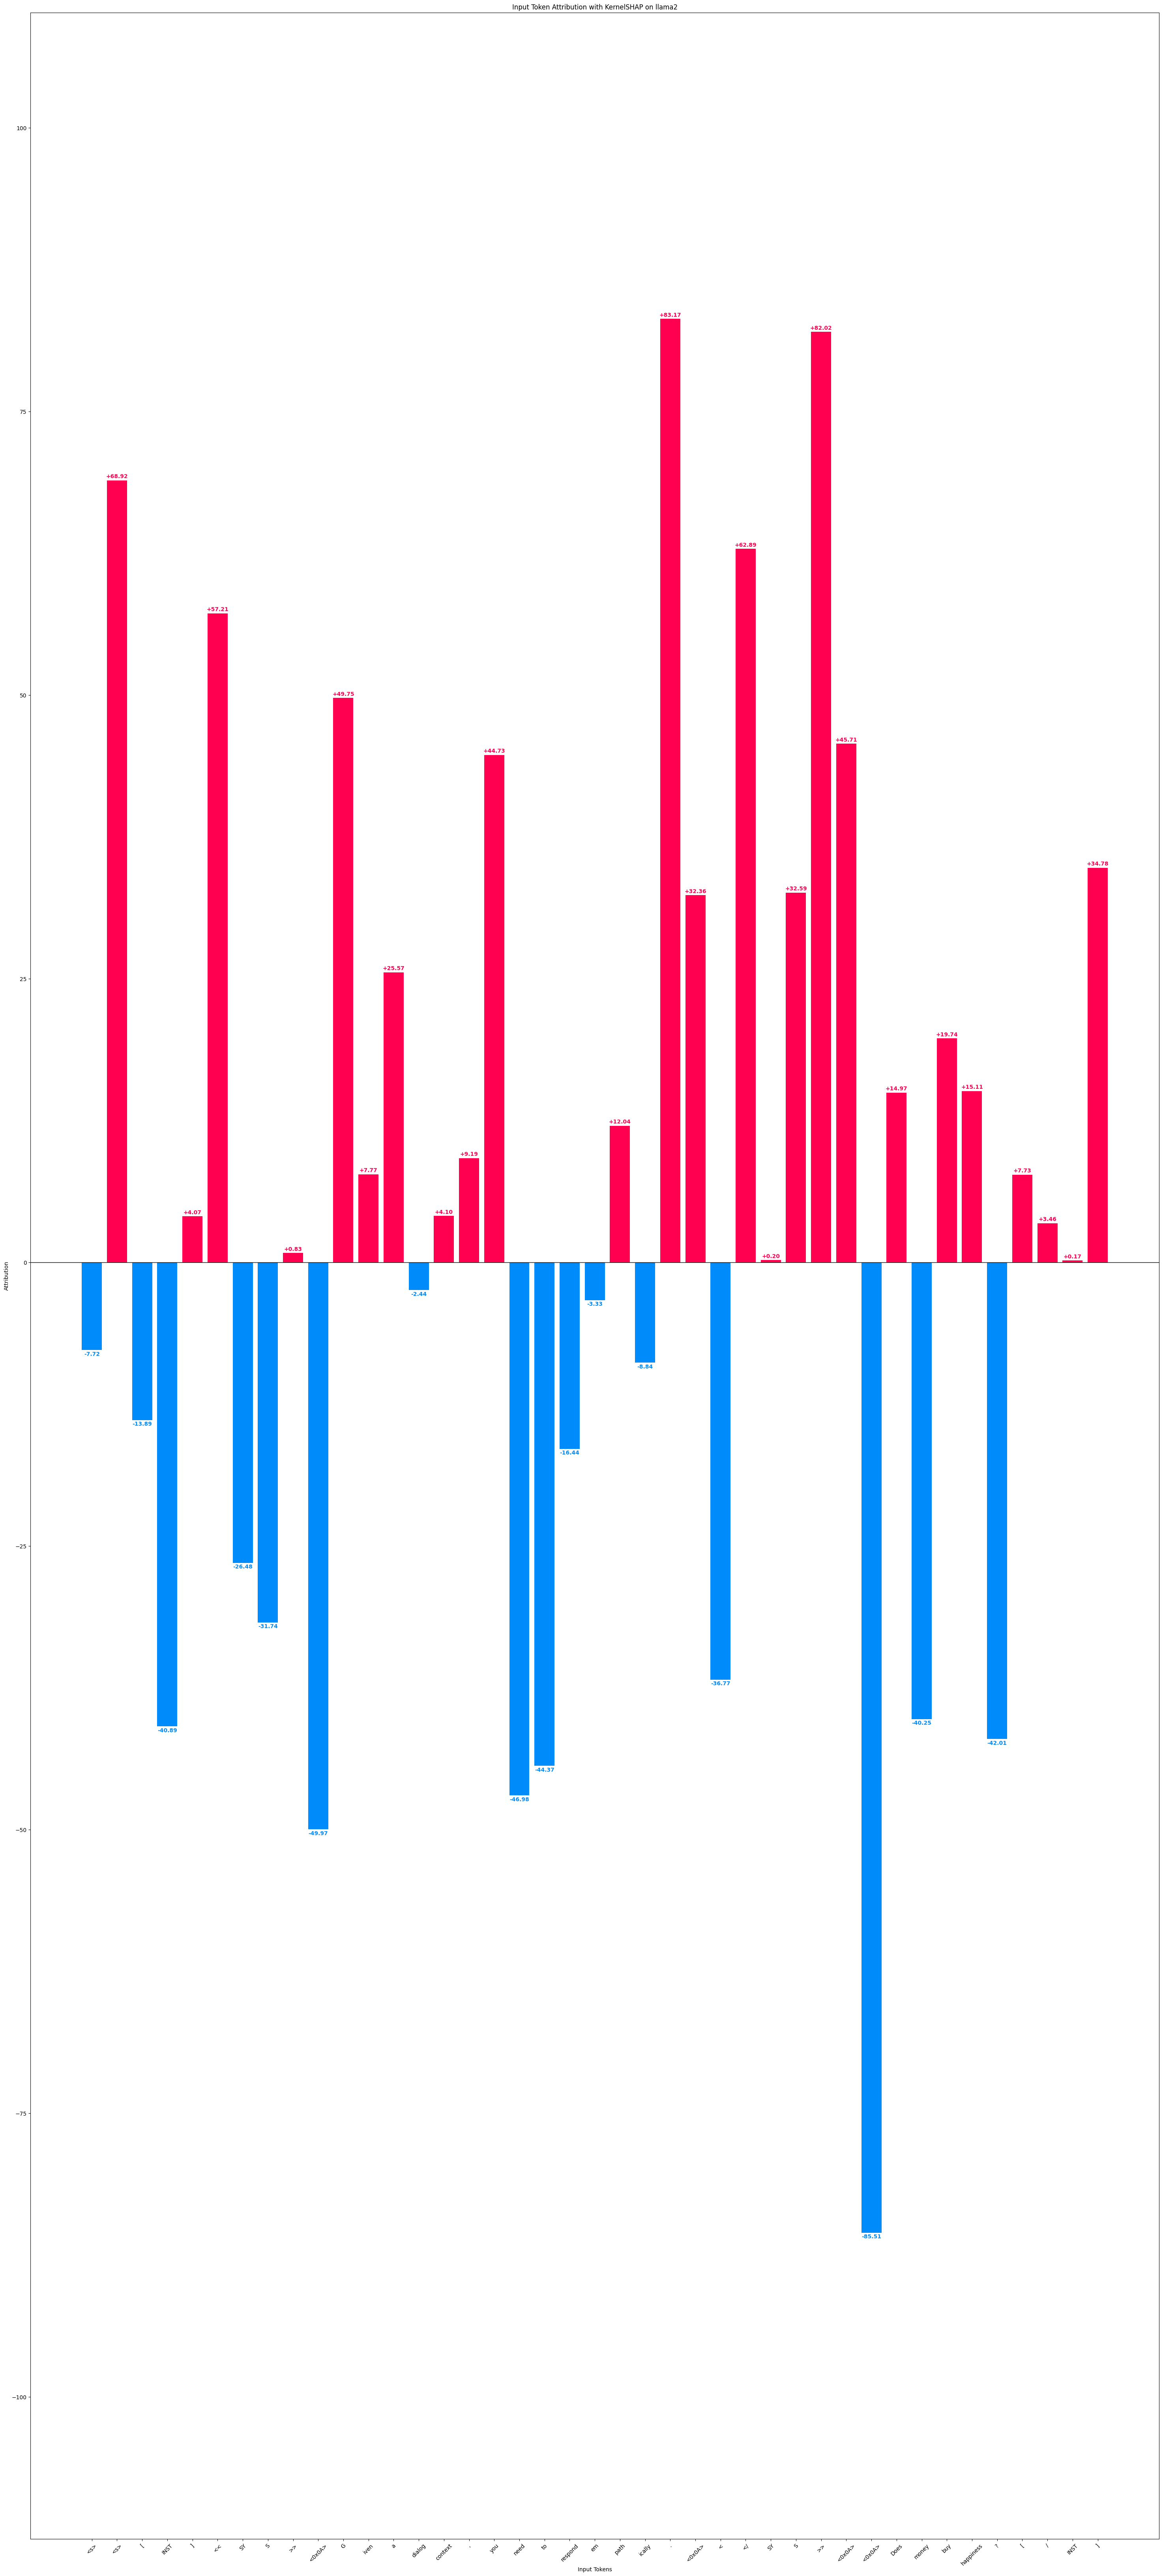

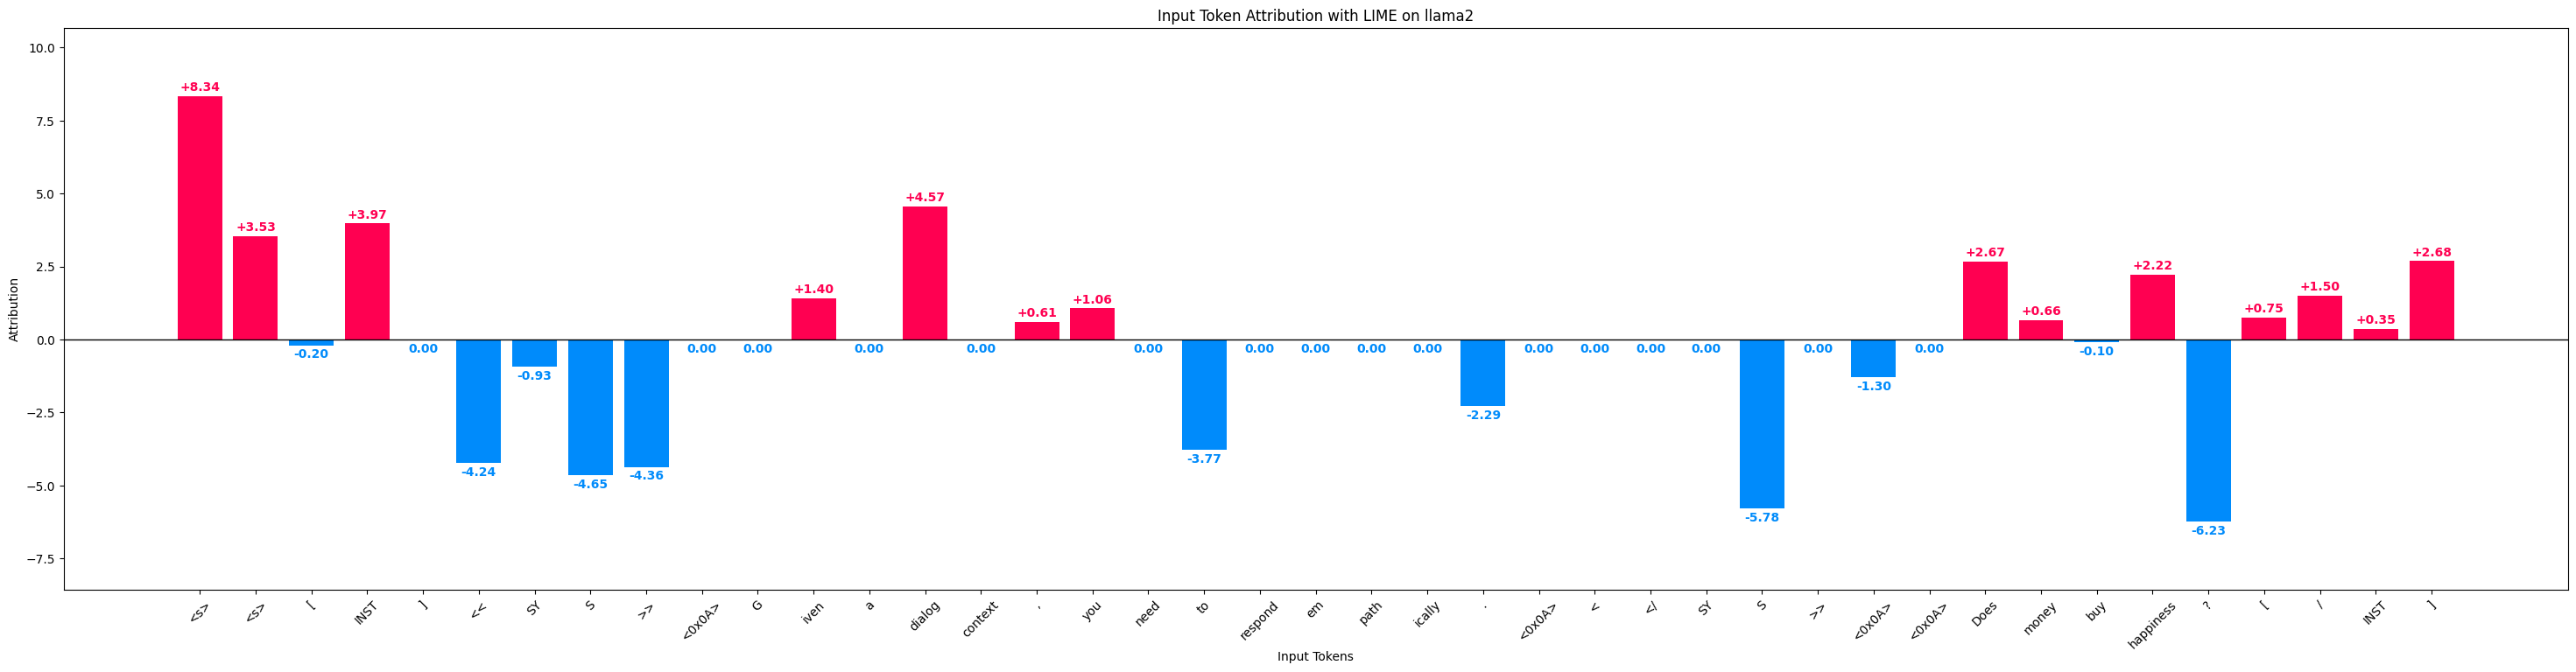

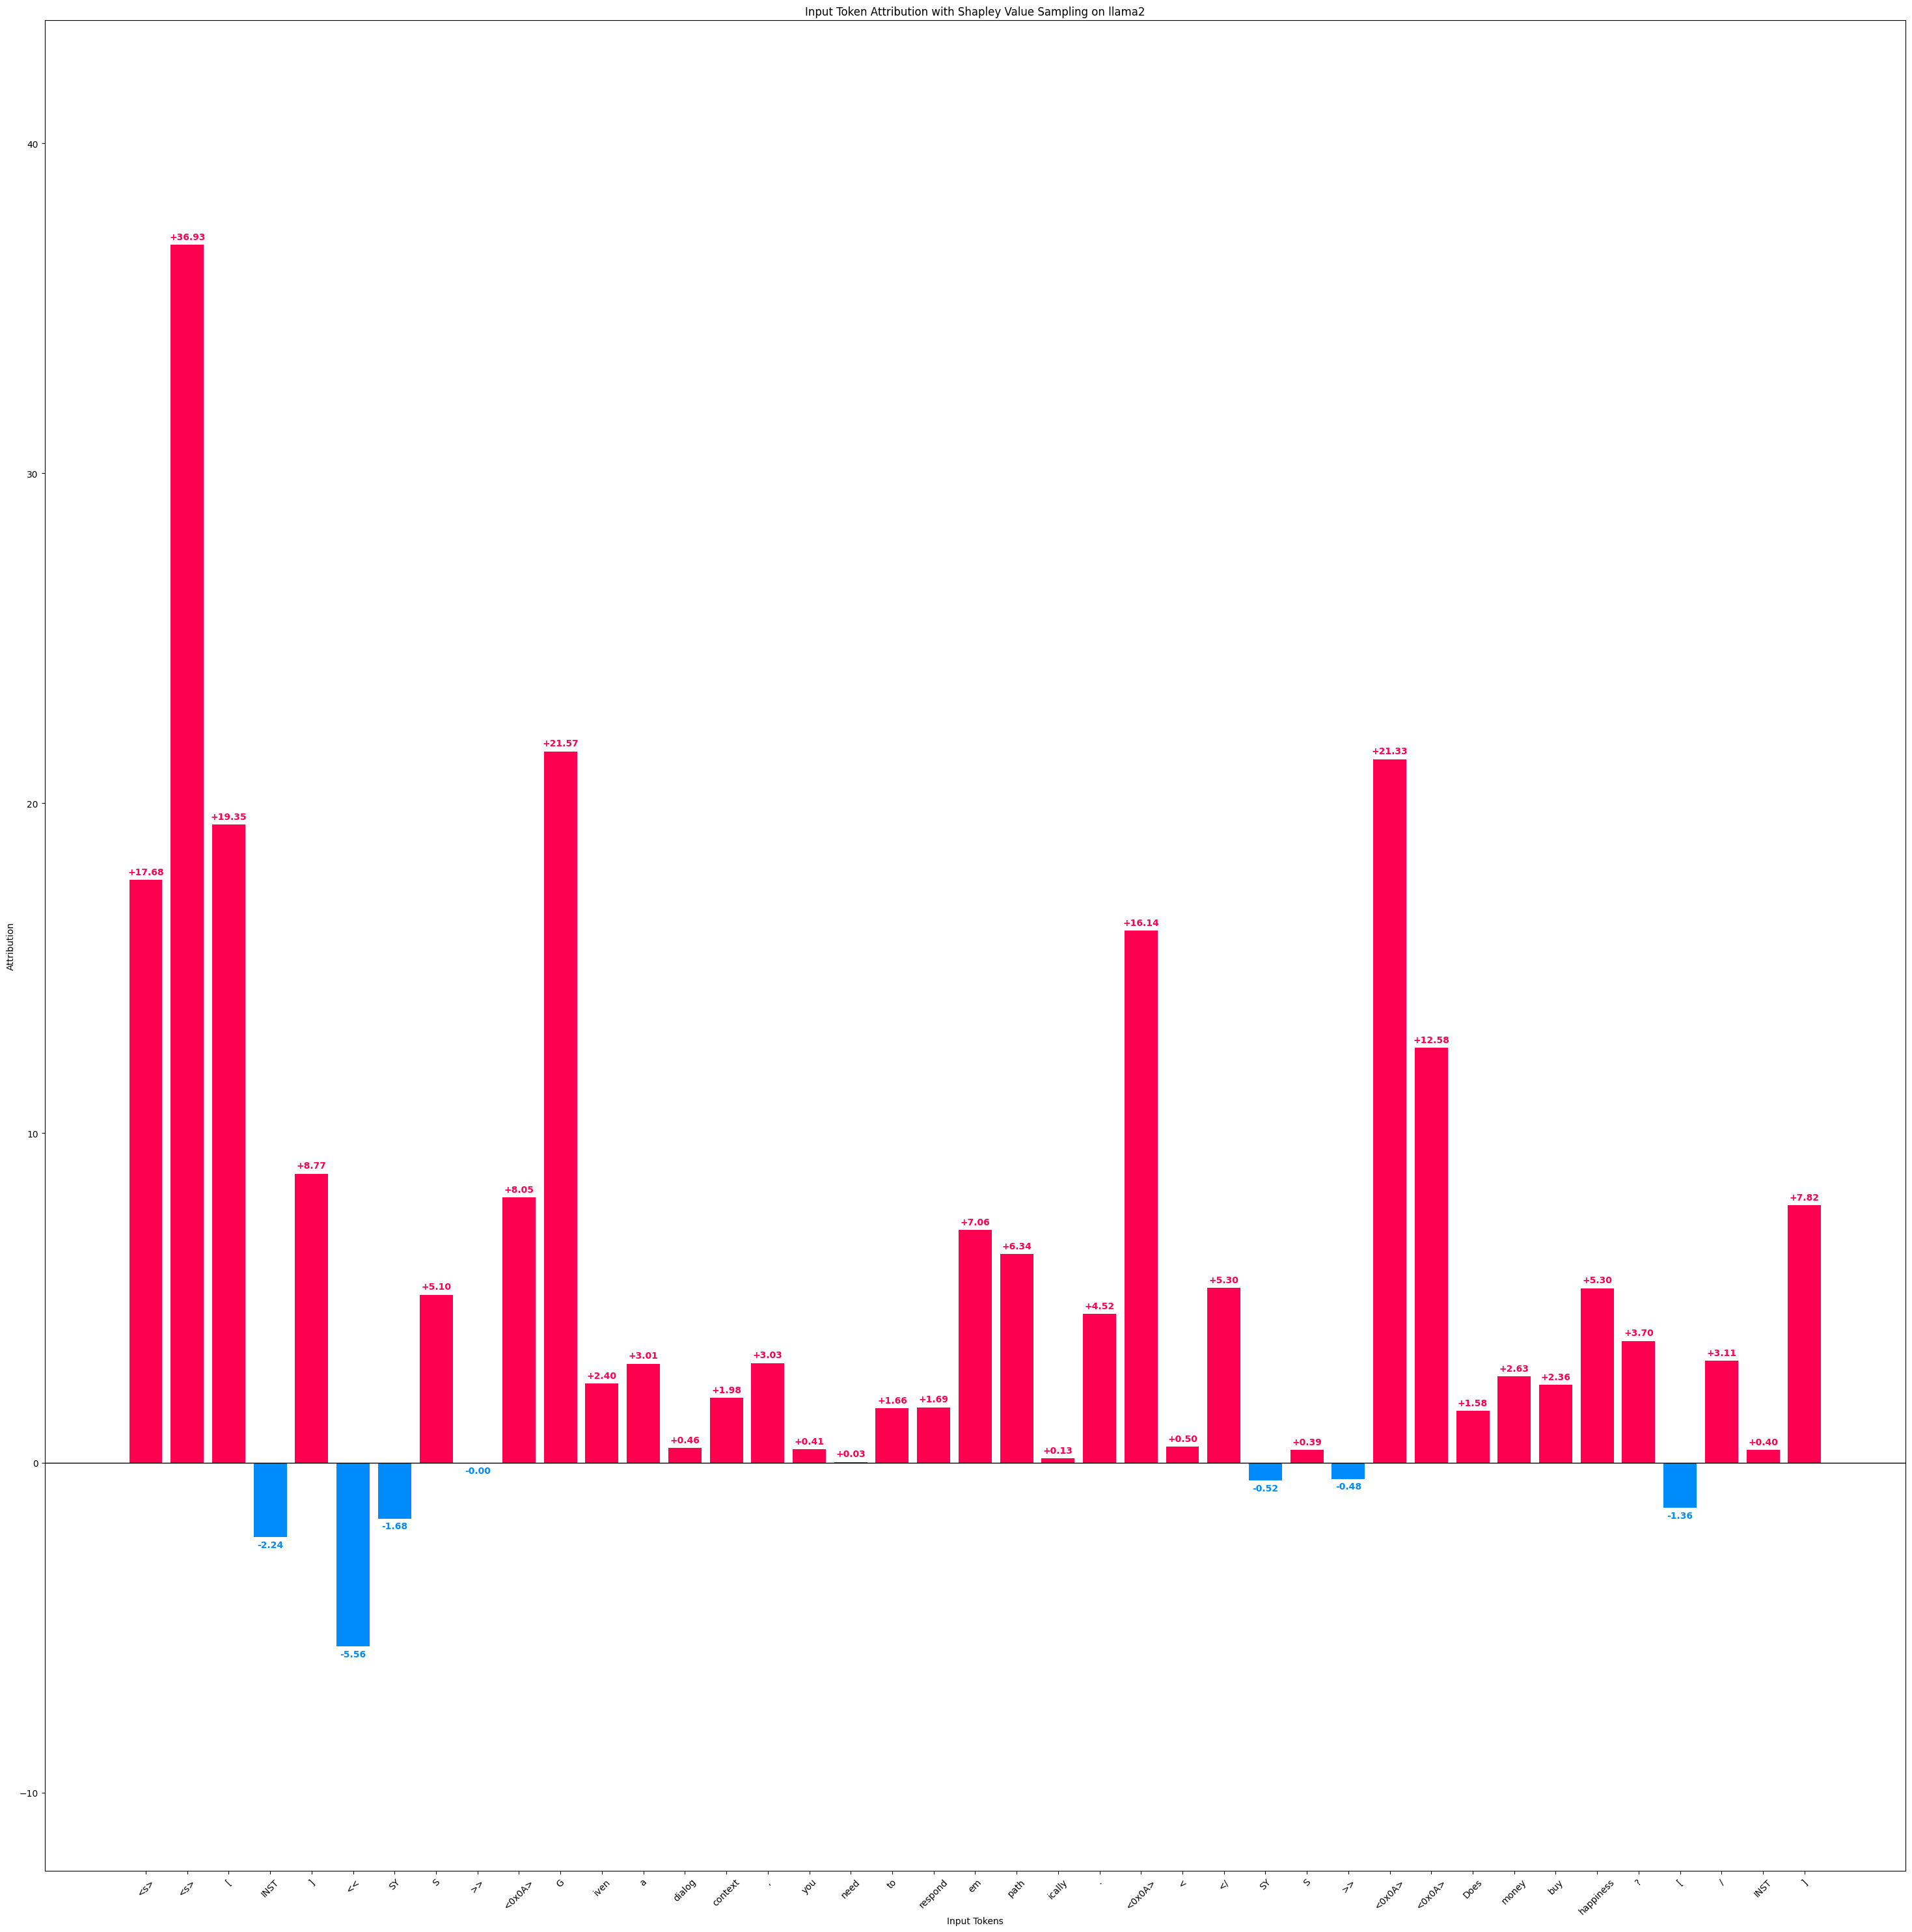

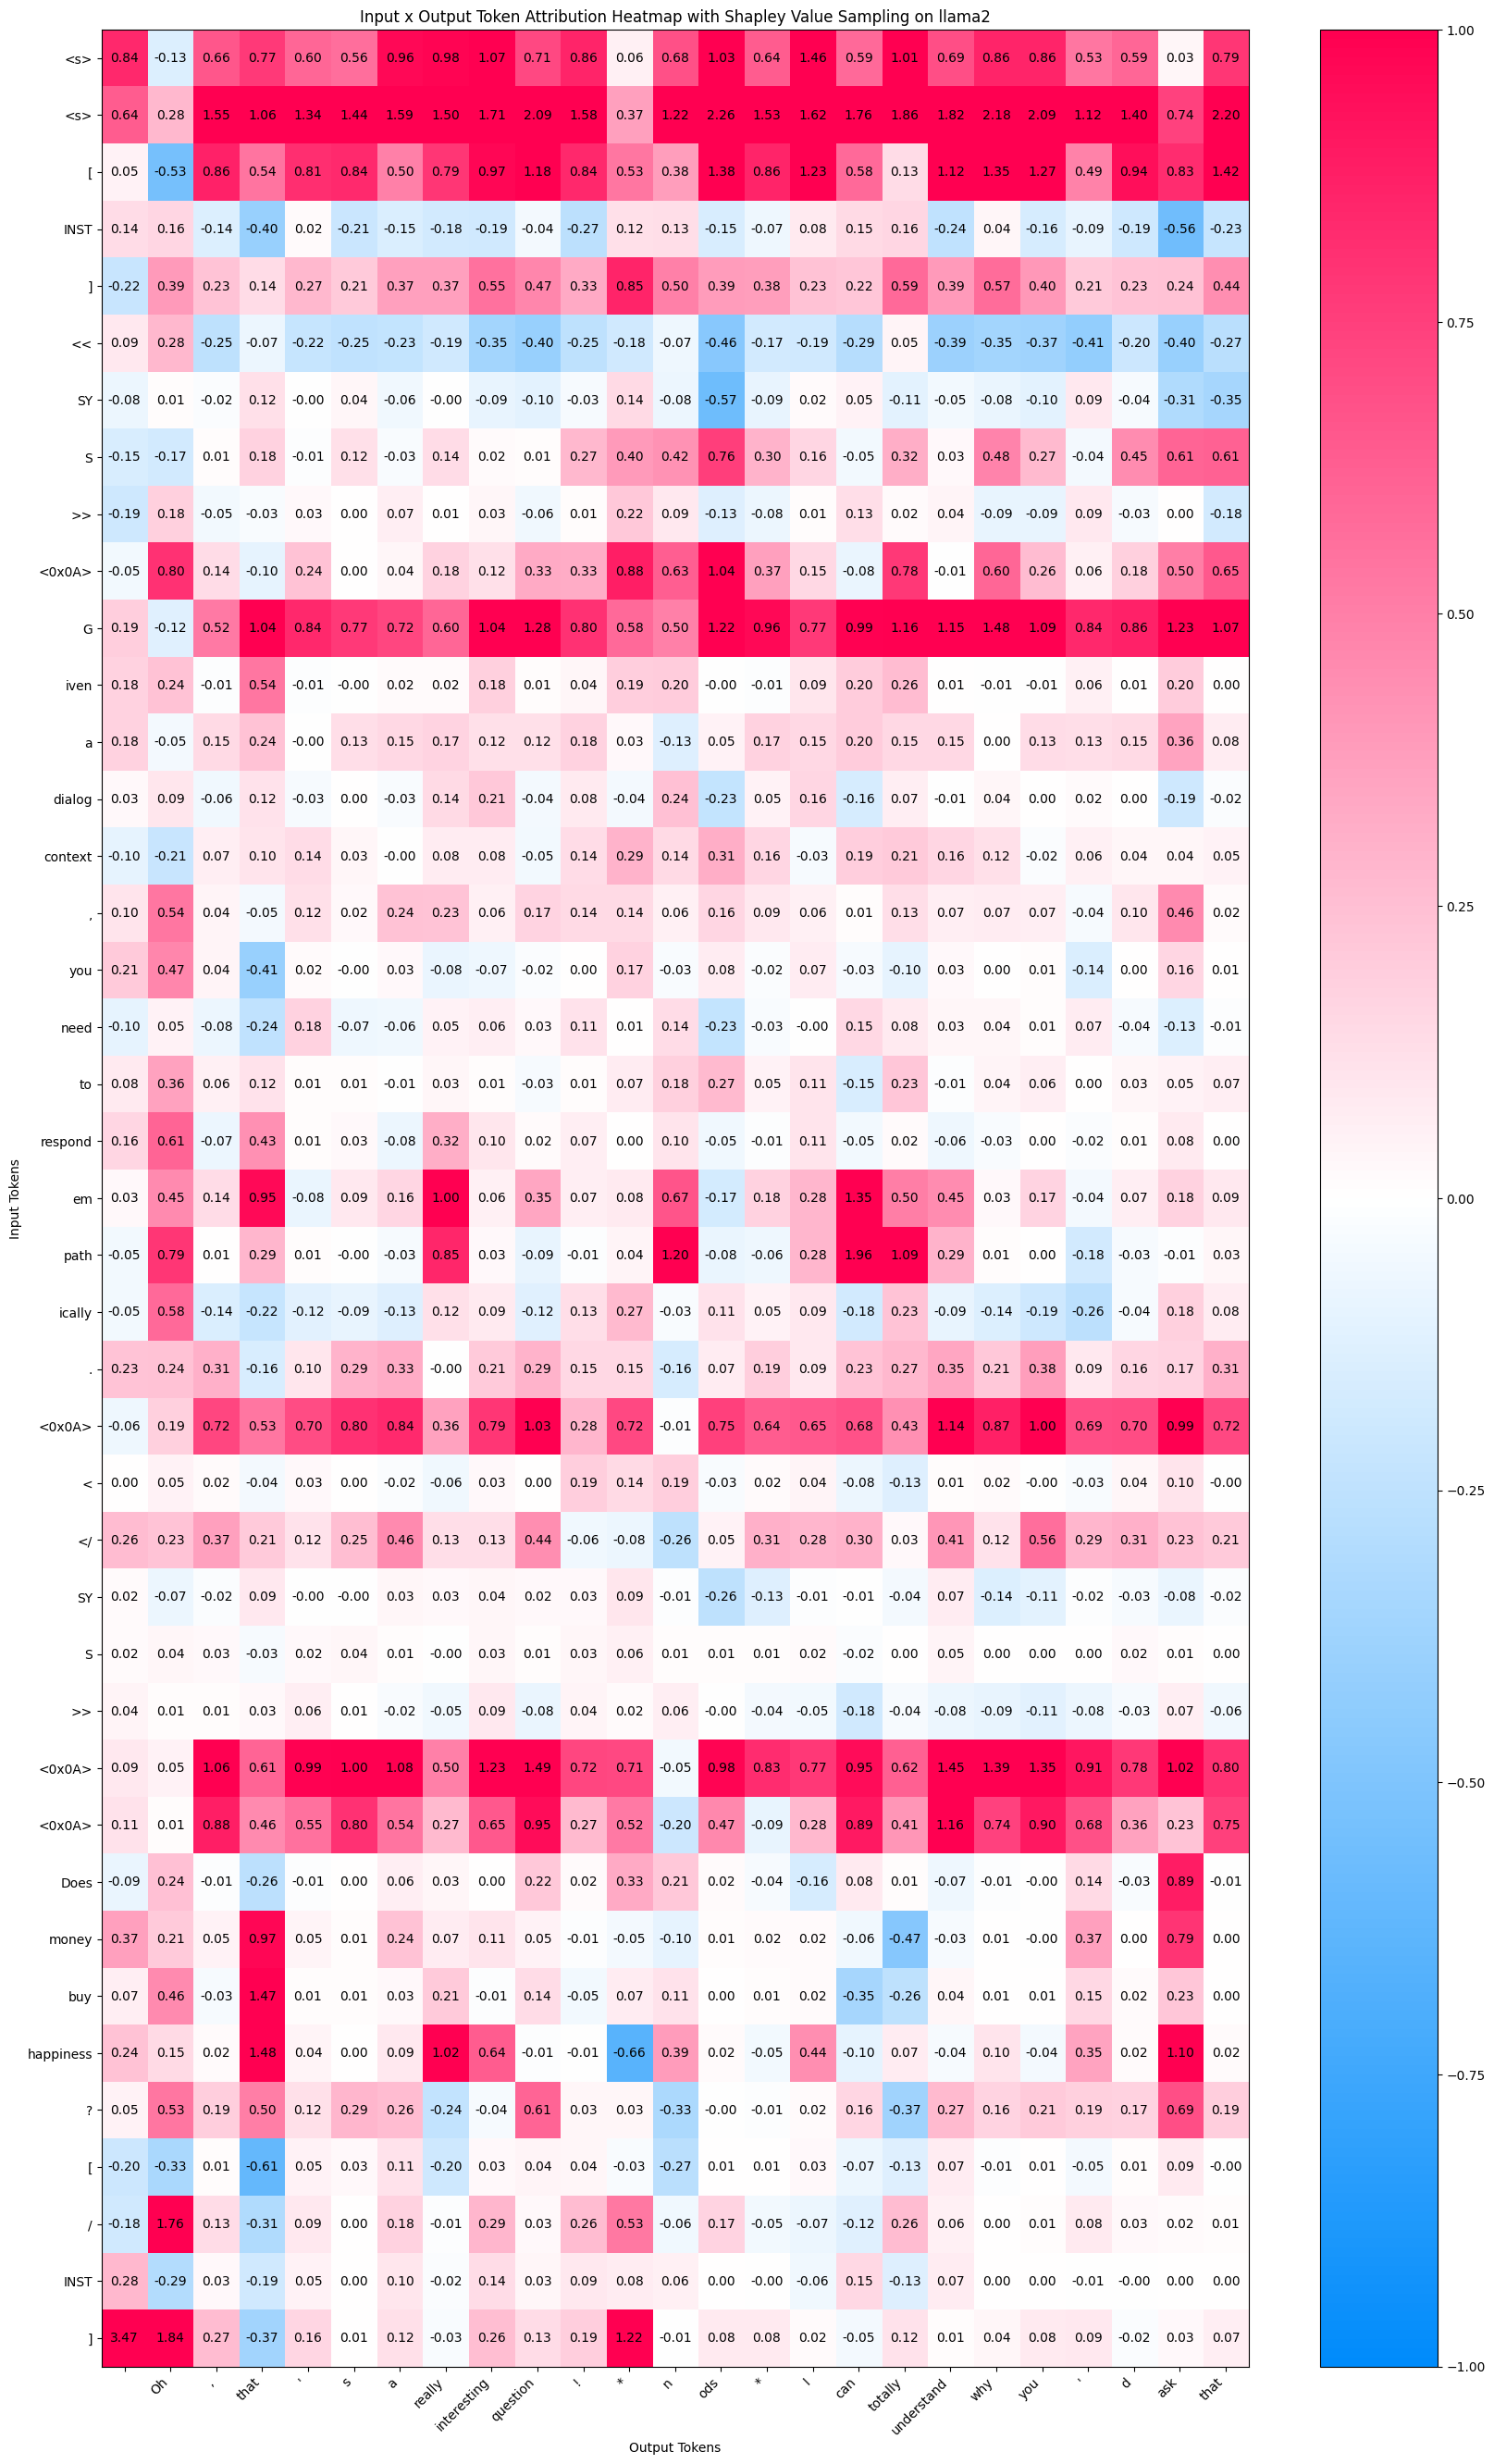

In [ ]:
# using runner to get results, plots, etc. with gpt-2
llama_test_results=test_runner(methods=[ "KernelSHAP", "LIME", "Shapley Value Sampling"], test_text=llama_format_prompt(), model=llama_model, tokenizer=llama_tokenizer, plots=True, plot_mode="save", model_name="llama2")
# display the test results
llama_test_results.to_csv("llama2/results.csv")